# L’analyse du commerce électronique brésilien

#### Père castor raconte moi une histoire....

## Importations des librairies

In [50]:
import pandas as pd, numpy as np, os, warnings, seaborn as sns
from datetime import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
font1 = fm.FontProperties(size=20)
font2 = fm.FontProperties(size=24)

# %matplotlib inline
%pylab inline

if int(str(sns.__version__).split('.')[1]) > 8 : 
    plt.style.use('seaborn-v0_8-darkgrid')
else:
    plt.style.use('seaborn-darkgrid')
    
sns.set(font_scale=2)
warnings.filterwarnings(action="ignore")

os.chdir("C:/Users/etien/Documents/CCI/_HUB/cours/2024-2025/big_data/_git/Python_pandas/donnees")

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Importations des doonées 

In [51]:
ventes = pd.read_parquet('ecommerce/analyse_ventes.parquet', engine='pyarrow')
ventes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 68 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   order_id            99441 non-null  object        
 1   customer_id         99441 non-null  object        
 2   purchase_timestamp  99441 non-null  datetime64[us]
 3   approved_at         99281 non-null  datetime64[us]
 4   delivered_carrier   97658 non-null  datetime64[us]
 5   delivered_customer  96476 non-null  datetime64[us]
 6   estimated_delivery  99441 non-null  datetime64[us]
 7   status              99441 non-null  object        
 8   annee               99441 non-null  int32         
 9   mois                99441 non-null  int32         
 10  annee_mois          99441 non-null  int32         
 11  jour                99441 non-null  int32         
 12  annee_jour          99441 non-null  int32         
 13  jour_semaine        99441 non-null  int32     

### Concaténation de vente et produit

In [52]:
produits = pd.read_parquet('ecommerce/products.parquet', engine='pyarrow')
# produit.info()

In [53]:
achat = pd.read_parquet('ecommerce/analyse_achat.parquet', engine='pyarrow')
achat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 51 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   order_id            112650 non-null  object        
 1   order_item_id       112650 non-null  int64         
 2   product_id          112650 non-null  object        
 3   seller_id           112650 non-null  object        
 4   price               112650 non-null  float64       
 5   freight_value       112650 non-null  float64       
 6   shipping_limit      112650 non-null  datetime64[us]
 7   limit               112650 non-null  float64       
 8   name_lenght         111047 non-null  float64       
 9   description_lenght  111047 non-null  float64       
 10  photos_qty          111047 non-null  float64       
 11  weight_g            112632 non-null  float64       
 12  length_cm           112632 non-null  float64       
 13  height_cm           112632 no

In [54]:
ventes_achat = ventes.merge(achat[['order_id', 'product_id', 'category_name']], on='order_id', how='left')
ventes_achat_produits = ventes_achat.merge(produits[['product_id', 'weight_g', 'length_cm', 'height_cm', 'width_cm']], 
                                         on='product_id', how='left')
#ventes_achat_produits.info()

#### Nettoyage des valeurs extrem

In [55]:
ventes_achat_produits = ventes_achat_produits[(ventes_achat_produits['weight_g'] > 0) & (ventes_achat_produits['weight_g'] < ventes_achat_produits['weight_g'].quantile(0.99))]
ventes_achat_produits = ventes_achat_produits[(ventes_achat_produits['livree'] > 0) & (ventes_achat_produits['livree'] < ventes_achat_produits['livree'].quantile(0.99))]

### Concaténation de vente et moyen de payement

In [56]:
orders_payments = pd.read_parquet('ecommerce/orders_payments.parquet', engine='pyarrow')
#orders_payments.info()

In [57]:
ventes_payement = ventes.merge(achat[['order_id', 'category_name']], on='order_id', how='left')
ventes_payement['payment_method'] = ventes_payement[['int_boleto', 'int_credit_card', 'int_debit_card', 'int_voucher']].idxmax(axis=1)
#ventes_achat.info()

In [58]:
payment_labels = {
    'int_boleto': 'Boleto',
    'int_credit_card': 'Carte de crédit',
    'int_debit_card': 'Carte de débit',
    'int_voucher': 'Voucher'
}
ventes_payement['payment_method'] = ventes_payement['payment_method'].map(payment_labels)

### 1/ Les temps de livraison dépendent-ils de facteurs annexes ?

Quelles dimensions a un impact sur le temps de livraison 

In [59]:
deliveryTime_by_period = ventes.groupby(['state', 'city', 'annee_trimestre'])['livree'].mean().reset_index()
deliveryTime_by_period

state             city  annee_trimestre     livree
0        AC        brasileia            20171   0.900000
1        AC  cruzeiro do sul            20174   2.297639
2        AC  cruzeiro do sul            20182  23.540556
3        AC   epitaciolandia            20174  10.963889
4        AC    manoel urbano            20173  11.257222
...     ...              ...              ...        ...
13524    TO   tocantinopolis            20174   3.322083
13525    TO   tocantinopolis            20181   4.264167
13526    TO   tocantinopolis            20182  10.511111
13527    TO          xambioa            20174   3.153056
13528    TO          xambioa            20183   8.562778

[13529 rows x 4 columns]

In [60]:
periode = ventes['annee_trimestre']


### 1 - Distribution des temps de livraison par état

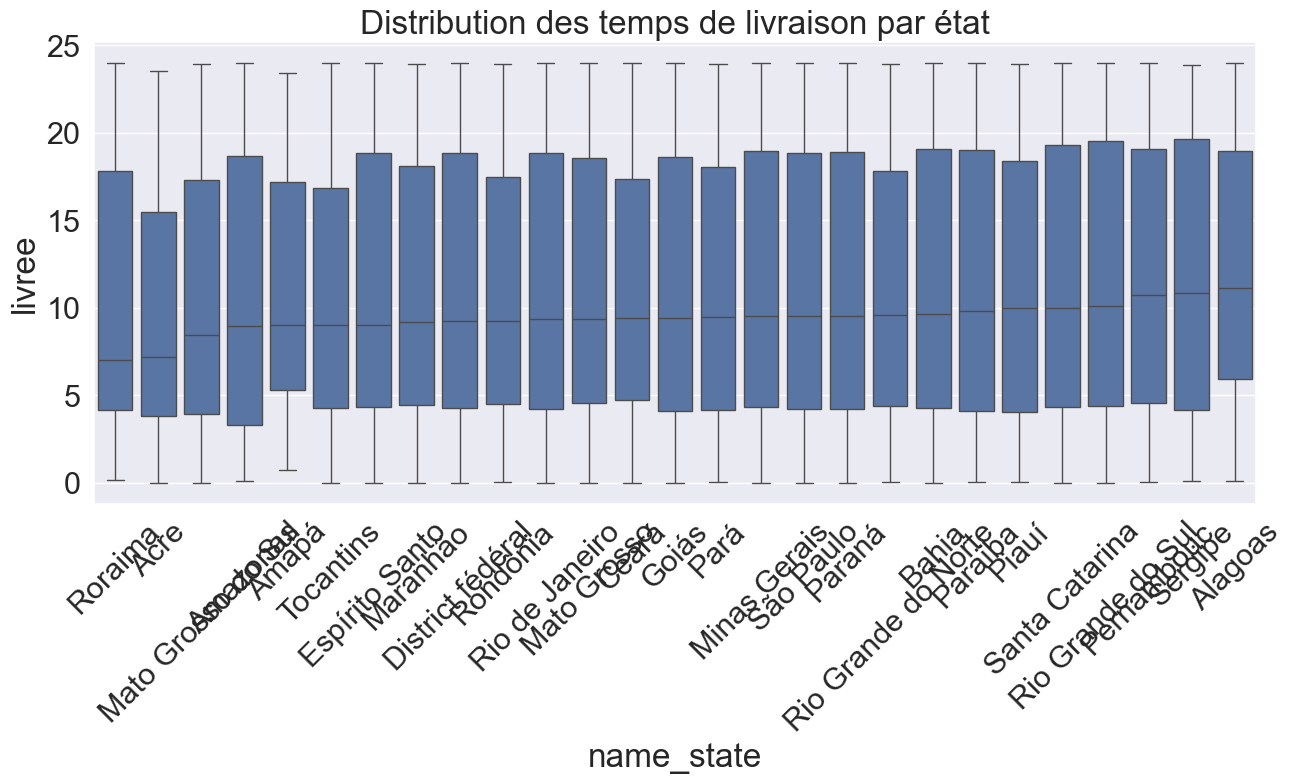

In [61]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=ventes, x='name_state', y='livree', order=ventes.groupby('name_state')['livree'].median().sort_values().index)
plt.xticks(rotation=45)
plt.title('Distribution des temps de livraison par état')
plt.show()

In [62]:
TO_deliveryTime_by_period = deliveryTime_by_period[deliveryTime_by_period['state'] == 'TO']
mask = ventes['annee_trimestre'].isin(periode) 
TO_deliveryTime_by_period = TO_deliveryTime_by_period[mask]
TO_deliveryTime_by_period.head(200)


state                  city  annee_trimestre     livree
13409    TO  alianca do tocantins            20181  23.877778
13410    TO  alianca do tocantins            20182  23.972222
13411    TO                 almas            20172  21.915556
13412    TO              alvorada            20172  19.882778
13413    TO              alvorada            20173  11.885833
...     ...                   ...              ...        ...
13524    TO        tocantinopolis            20174   3.322083
13525    TO        tocantinopolis            20181   4.264167
13526    TO        tocantinopolis            20182  10.511111
13527    TO               xambioa            20174   3.153056
13528    TO               xambioa            20183   8.562778

[120 rows x 4 columns]

### 2 - Densité des temps de livraison pas période

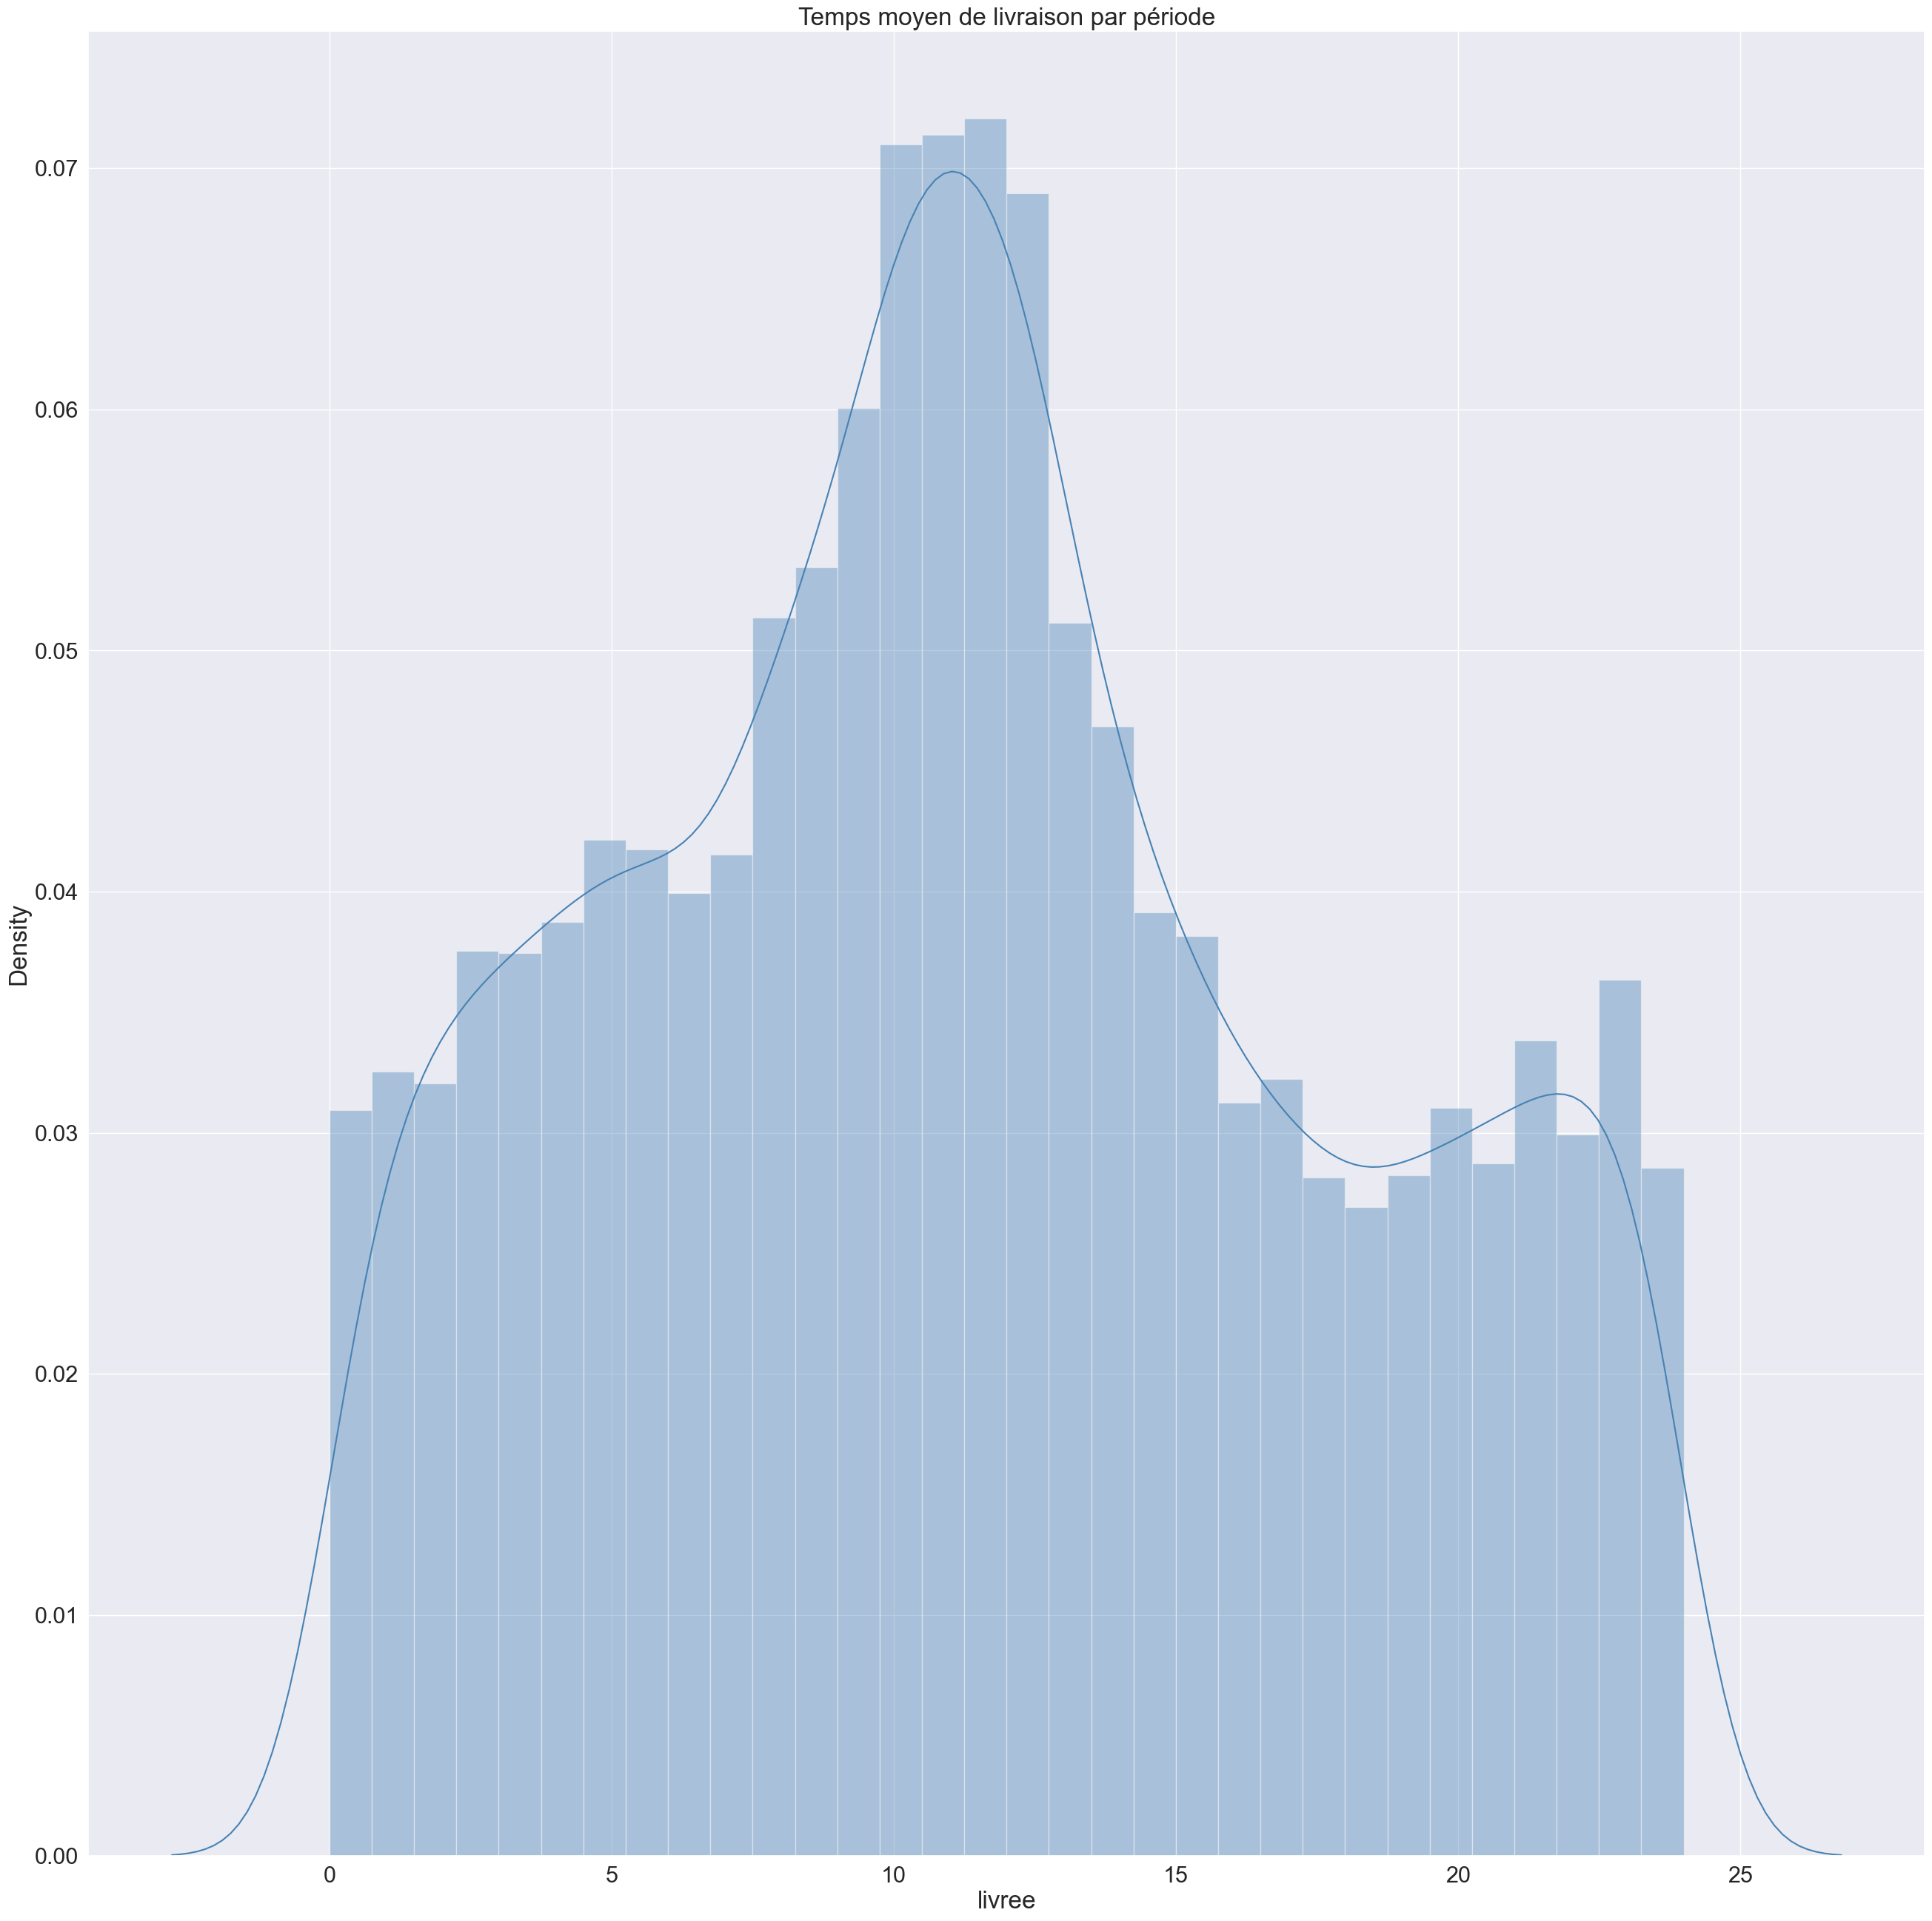

In [63]:
plt.figure(figsize=(32,32))
plt.title('Temps moyen de livraison par période', fontproperties=font2)
sns.distplot(deliveryTime_by_period['livree'], color="steelblue")
plt.show()

 interquartile range => là où se site 

### 3 - représentaion de la distribution des temps de livraison par état

RR  :  9.886470189701896
AC  :  9.55711111111111


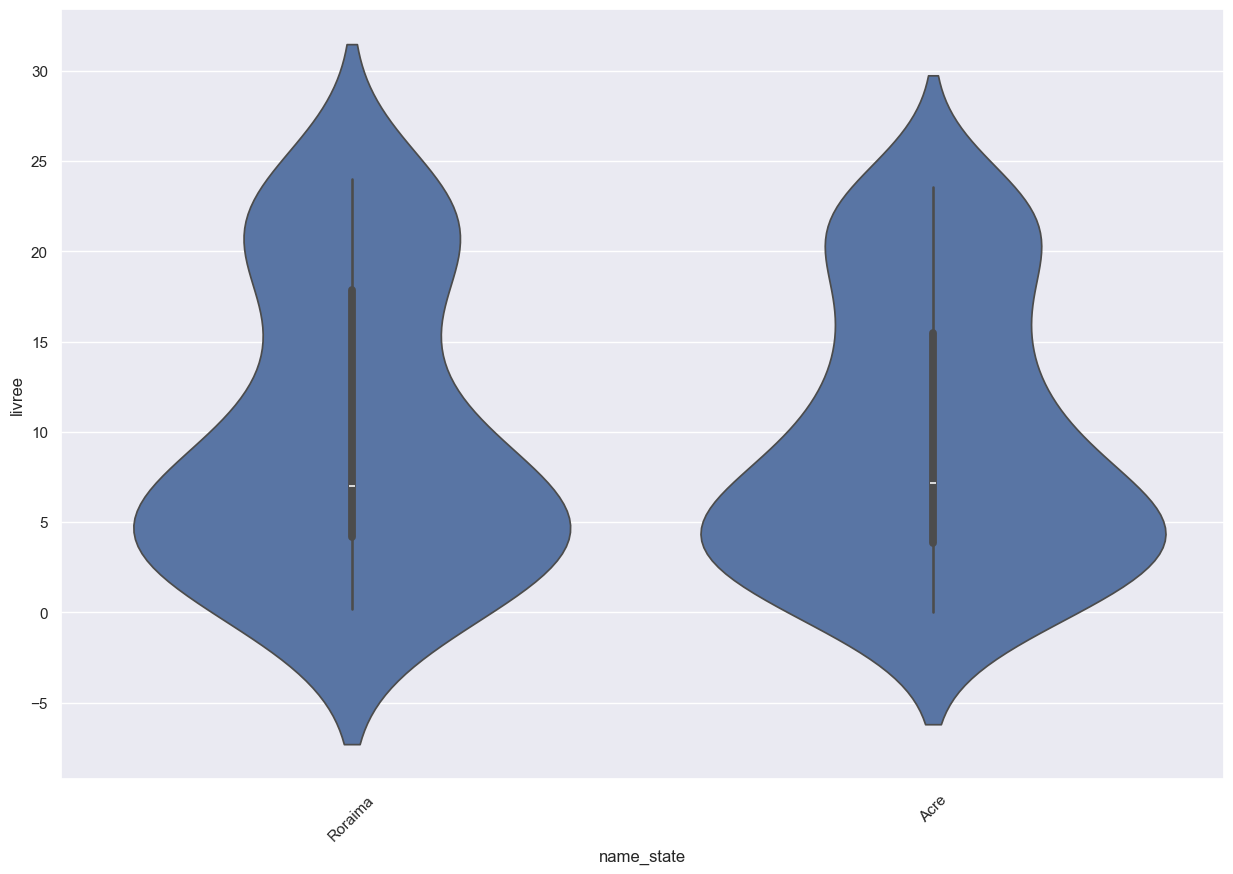

In [64]:
# https://mode.com/blog/violin-plot-examples


sns.set_theme(rc={'figure.figsize':(15, 10)})

country = ventes['state'].unique()

def getCountry_by_meanDelivery(country, nMean = 10):
    result = pd.DataFrame()
    for i in range(len(country)):
        countryName = country[i]
        currentCountryData = ventes[ventes['state'] == countryName] 
        if(currentCountryData["livree"].mean() < nMean):
            print(countryName, " : ", currentCountryData["livree"].mean())
            result = pd.concat([result, currentCountryData], ignore_index = True)
    return result

data = getCountry_by_meanDelivery(country, 10)

#print(data.info())

sns.violinplot(data = data, x = 'name_state', y = 'livree', width=0.8)
plt.xticks(rotation=45)
plt.show()

### 4 - Carte des temps de livraison moyen

ajouter un colonne temps de livraison moyen par état

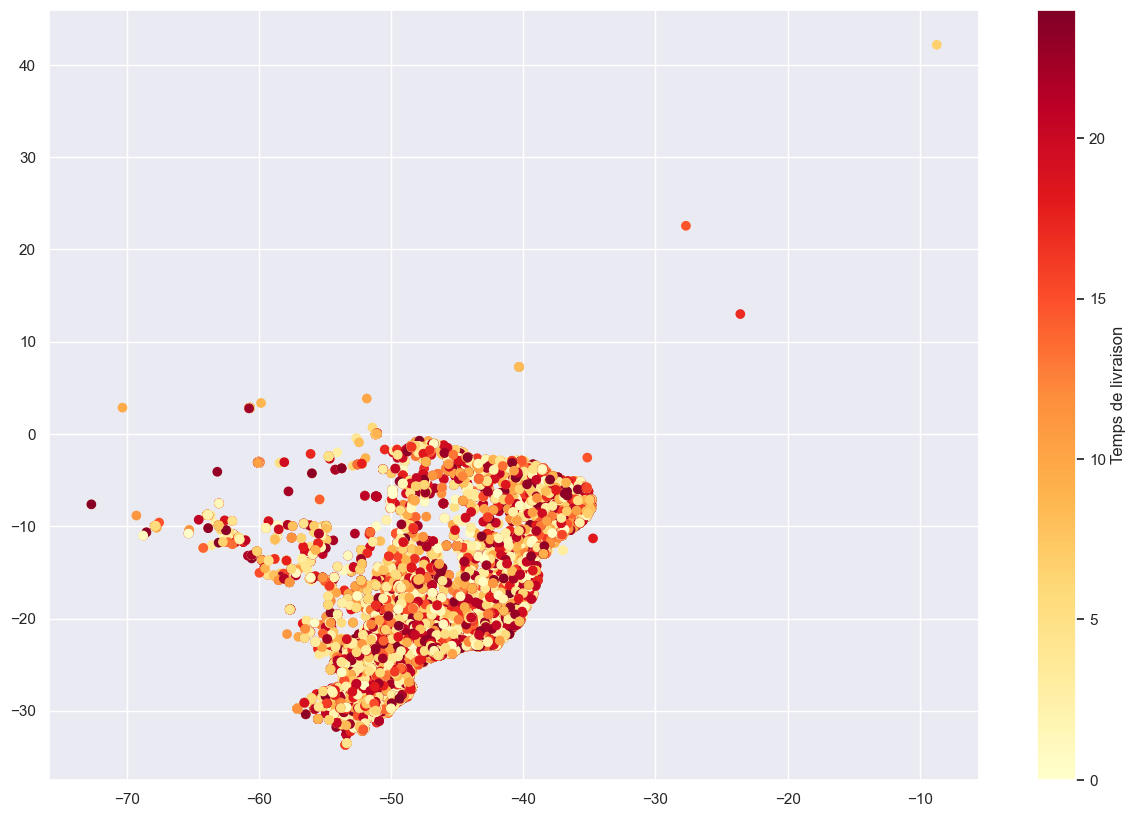

In [65]:
plt.scatter(ventes['lng'], ventes['lat'], c=ventes['livree'], cmap='YlOrRd')
plt.colorbar(label='Temps de livraison')
plt.show()

### 5 - Temps de livraison moyen par trimestre et par ville 

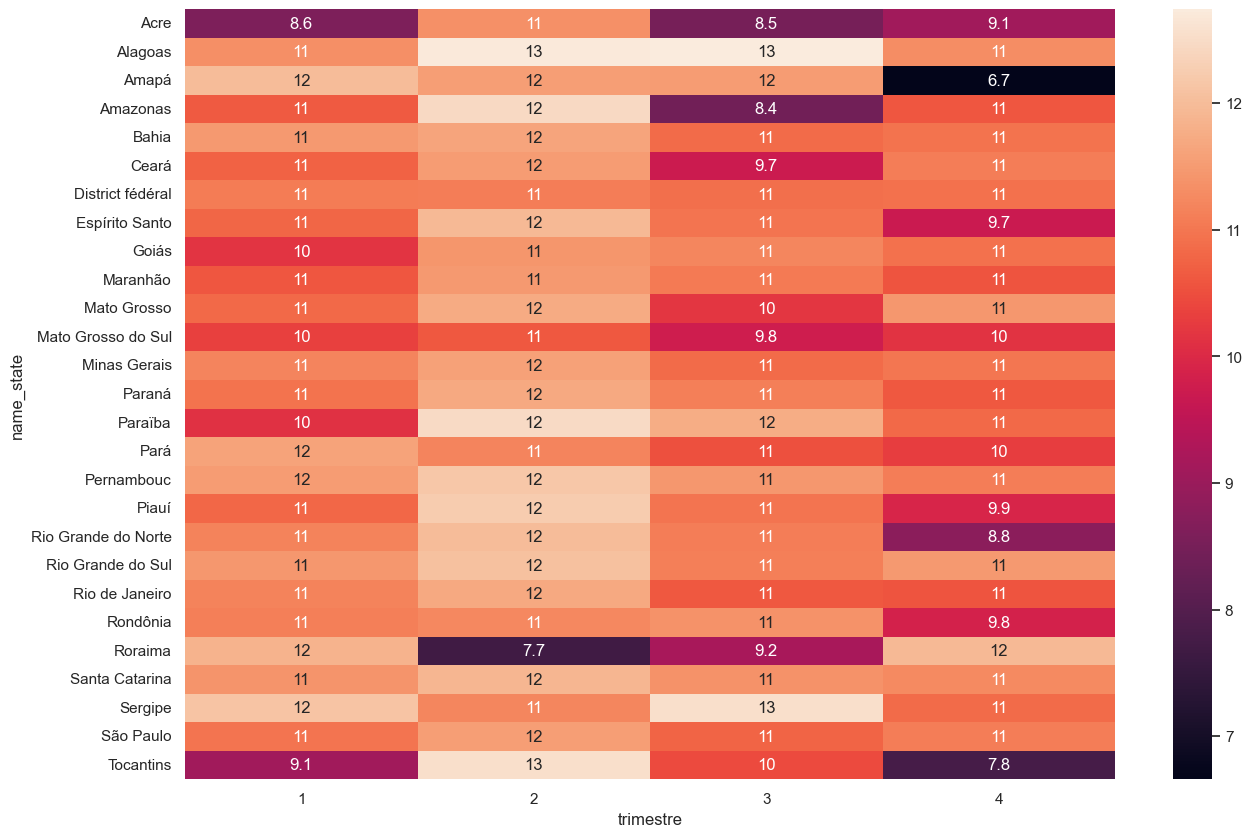

In [66]:
delivery_heatmap = ventes.pivot_table(
    values='livree',
    index='name_state',
    columns='trimestre',
    aggfunc='mean'
)
sns.heatmap(delivery_heatmap, annot=True)
plt.show()

### 6 - Comparaison des temps de livraison de tout les Etat

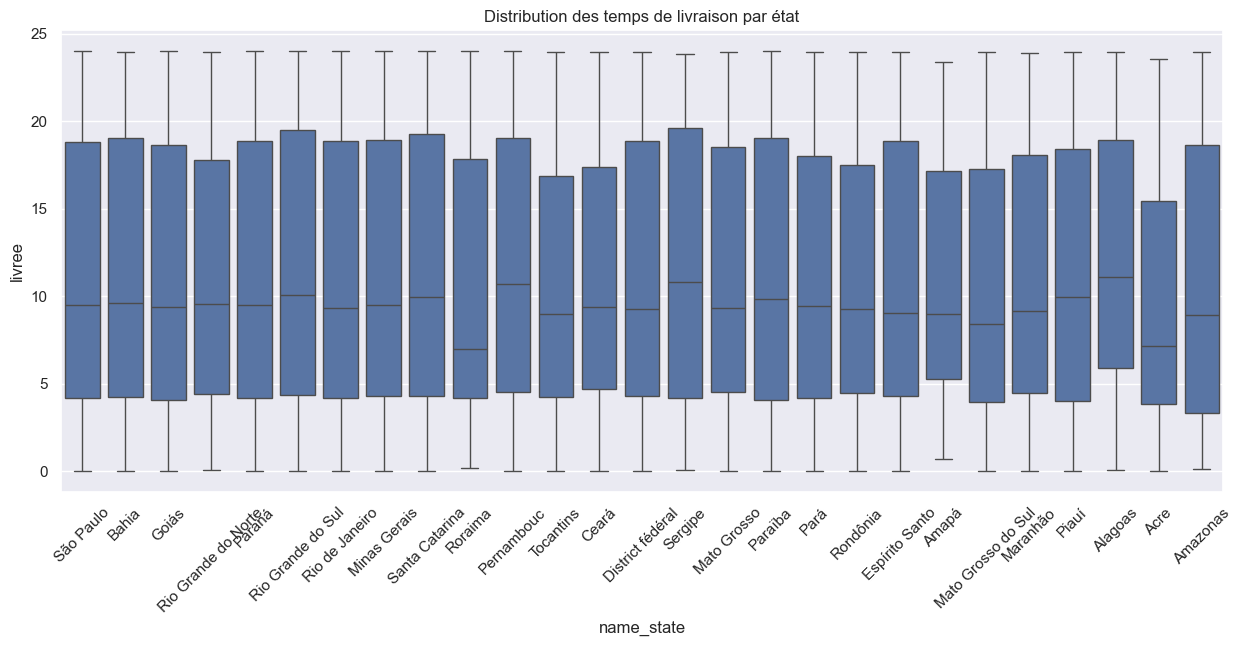

In [67]:
plt.figure(figsize=(15, 6))
sns.boxplot(data=ventes, x='name_state', y='livree')
plt.xticks(rotation=45)
plt.title('Distribution des temps de livraison par état')
plt.show()

### 7 - Evolution du temps de livraison par rapport au temps estimé en fonction du trimestre pour une région

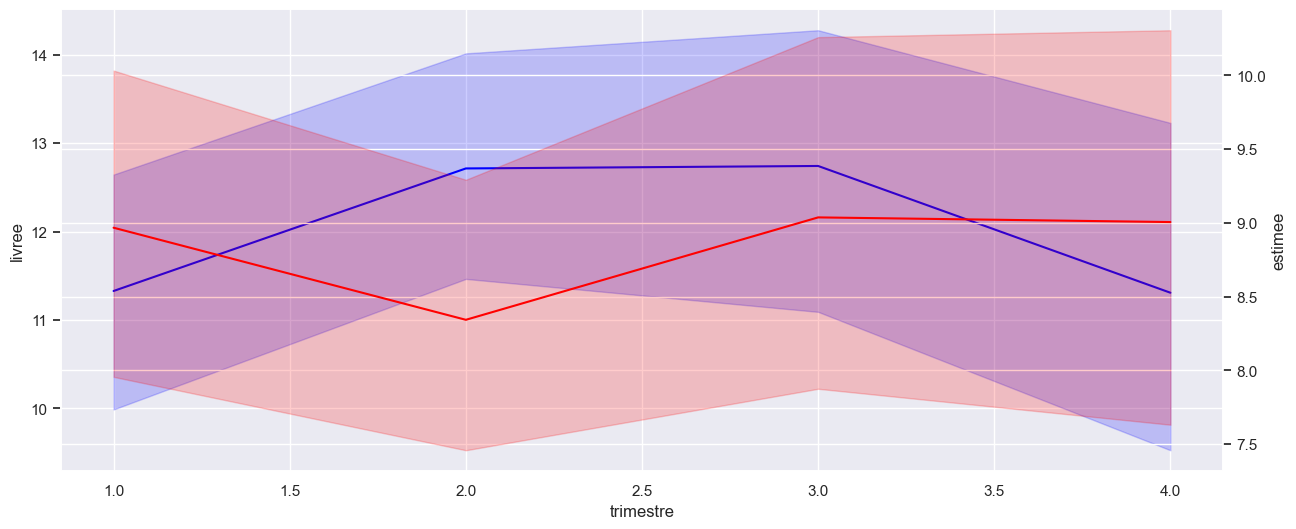

In [68]:
TO = ventes[ventes['state'] == 'AL']

fig, ax1 = plt.subplots(figsize=(15,6))
ax2 = ax1.twinx()
sns.lineplot(data=TO, x='trimestre', y='livree', ax=ax1, color='blue')
sns.lineplot(data=TO, x='trimestre', y='estimee', ax=ax2, color='red')
plt.show()

In [69]:

data = getCountry_by_meanDelivery(country, 10)

plt.figure(figsize=(15, 8))

sns.boxplot(data=data, 
            x='state',
            y='livree',
            hue='trimestre',
            palette='Set3')

plt.title('Temps de livraison par État et Trimestre', fontsize=14)
plt.xlabel('État', fontsize=12)
plt.ylabel('Temps de livraison (jours)', fontsize=12)
plt.xticks(rotation=45)

plt.legend(title='Trimestre')


plt.tight_layout()

plt.show()

RR  :  9.886470189701896
AC  :  9.55711111111111


#### 8 - Temps de livraison selon le poids du produit

In [70]:
plt.figure(figsize=(12,6))
sns.boxplot(x=pd.qcut(ventes_achat_produits['weight_g'], q=5), y=ventes_achat_produits['livree'])
plt.xticks(rotation=45)
plt.xlabel("Poids du produit (quantiles)")
plt.ylabel("Temps de livraison (jours)")
plt.title("Distribution des délais de livraison selon le poids du produit")
plt.show()

#### 9 - Relation Poids/Taille vs Temps de livraison

In [71]:
plt.figure(figsize=(12,6))
sns.scatterplot(data=ventes_achat_produits, x=ventes_achat_produits['weight_g'], y=ventes_achat_produits['livree'], alpha=0.5)
plt.xlabel("Poids du produit (g)")
plt.ylabel("Temps de livraison (jours)")
plt.title("Relation entre le poids du produit et le délai de livraison")
plt.show()

#### 10 - Retards en fonction des dimensions du produit 

In [72]:
ventes_achat_produits['volume_cm3'] = ventes_achat_produits['length_cm'] * ventes_achat_produits['height_cm'] * ventes_achat_produits['width_cm']

plt.figure(figsize=(12,6))
corr_matrix = ventes_achat_produits[['livree', 'weight_g', 'volume_cm3']].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Corrélation entre les dimensions des produits et le temps de livraison")
plt.show()

Il n'y a aucun rapport en le poids ou le volume et le délais de livraison. 

#### 11 - Temps moyen de livraison par mode de paiement

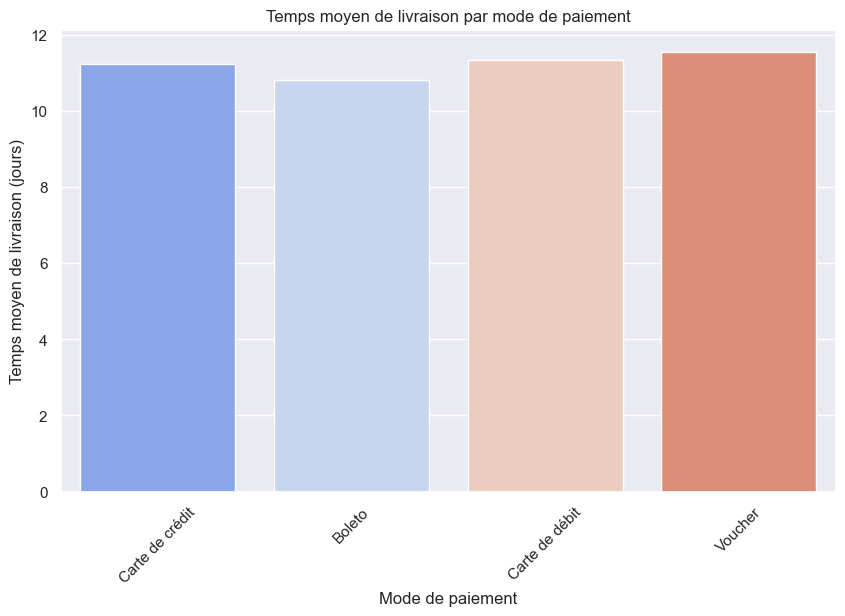

In [73]:
plt.figure(figsize=(10,6))
sns.barplot(data=ventes_payement, x='payment_method', y='livree', ci=None, palette="coolwarm")
plt.xlabel("Mode de paiement")
plt.ylabel("Temps moyen de livraison (jours)")
plt.title("Temps moyen de livraison par mode de paiement")
plt.xticks(rotation=45)
plt.show()

#### 12 - Comparaison des écarts de livraison selon le paiement

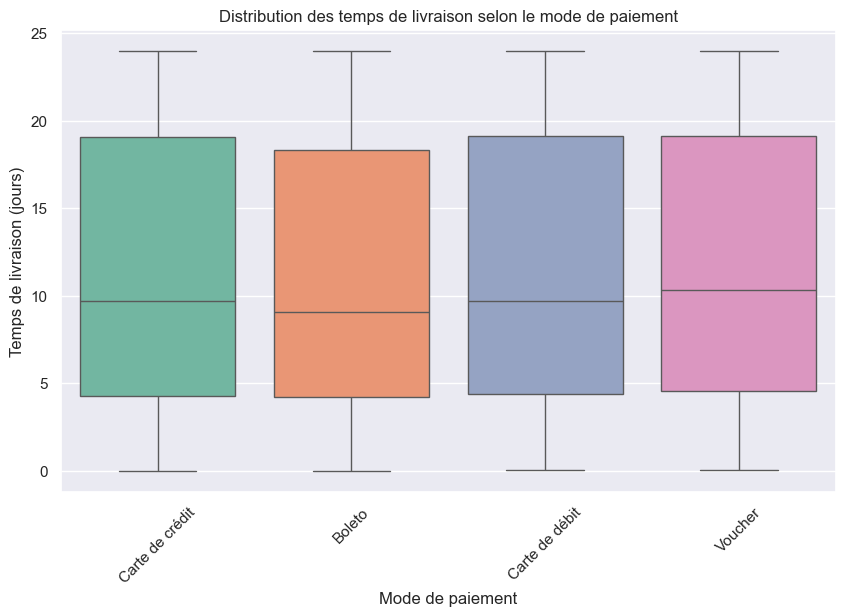

In [74]:
plt.figure(figsize=(10,6))
sns.boxplot(data=ventes_payement, x='payment_method', y='livree', palette="Set2")
plt.xlabel("Mode de paiement")
plt.ylabel("Temps de livraison (jours)")
plt.title("Distribution des temps de livraison selon le mode de paiement")
plt.xticks(rotation=45)
plt.show()

#### 13 - Répartition des paiements selon les délais

In [75]:

plt.figure(figsize=(10,6))
ventes_payement['livree_bins'] = pd.cut(ventes_payement['livree'], bins=[0, 5, 10, 15, 20, ventes_payement['livree'].max()], labels=["0-5j", "6-10j", "11-15j", "16-20j", "20j+"])
payment_delay_counts = ventes_payement.groupby(['livree_bins', 'payment_method']).size().unstack()
payment_delay_counts.plot(kind='bar', stacked=True, figsize=(12,6), colormap='viridis')
plt.xlabel("Délai de livraison")
plt.ylabel("Nombre de commandes")
plt.title("Répartition des paiements selon les délais de livraison")
plt.xticks(rotation=45)
plt.legend(title="Mode de paiement")
plt.show()

<Figure size 1000x600 with 0 Axes>

### 2/ Analyse de l'insatisfaction des clients
#### 1 - Score globaux de satisfaction 

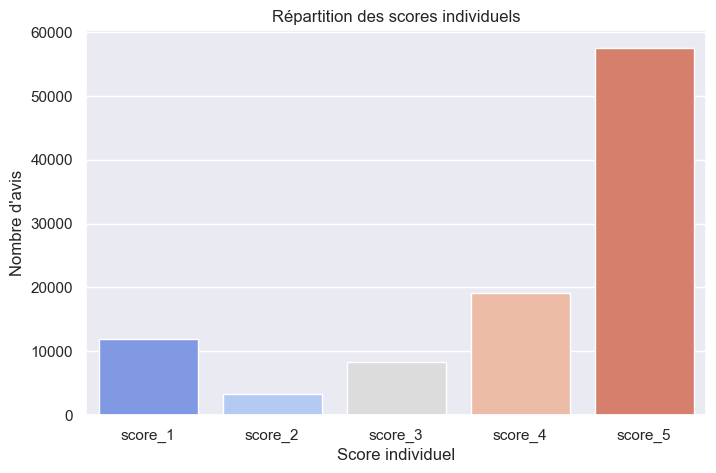

In [76]:
score_columns = ['score_1', 'score_2', 'score_3', 'score_4', 'score_5']
score_counts = ventes[score_columns].sum()

score_distribution = score_counts.reset_index()
score_distribution.columns = ['Score', 'Nombre']

plt.figure(figsize=(8,5))
sns.barplot(data=score_distribution, x='Score', y='Nombre', palette="coolwarm")
plt.xlabel("Score individuel")
plt.ylabel("Nombre d'avis")
plt.title("Répartition des scores individuels")
plt.show()

#### 2 - Proportion des retards

In [77]:
# Création d'une colonne "retard" (différence entre la date de livraison estimée et réelle)
ventes['retard'] = (ventes['delivered_customer'] - ventes['estimated_delivery']).dt.days

# Créer une catégorie pour indiquer si une commande est en retard
ventes['retard_categorie'] = ventes['retard'].apply(lambda x: 'En retard' if x > 0 else 'À l’heure ou en avance')


# Compter le nombre de commandes par catégorie
retard_counts = ventes['retard_categorie'].value_counts()

# Créer un barplot
plt.figure(figsize=(8, 6))
sns.barplot(x=retard_counts.index, y=retard_counts.values, palette="coolwarm")
plt.xlabel("Catégorie de retard")
plt.ylabel("Nombre de commandes")
plt.title("Nombre de commandes en retard vs à l'heure ou en avance")
for i, count in enumerate(retard_counts.values):
    plt.text(i, count + 100, f"{count}", ha='center', va='bottom', fontsize=12)
plt.show()

#### 3 - Score de satisfaction en fonction des délais de livraison 

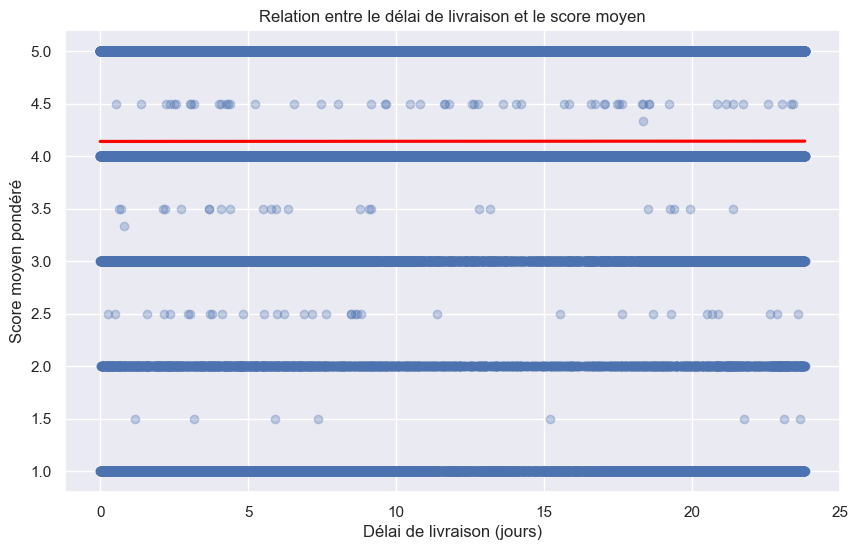

In [78]:
# Suppression des valeurs aberrantes dans les délais de livraison
df_filtered = ventes[ventes['livree'] <= ventes['livree'].quantile(0.99)]

# Moyenne pondérée des scores en fonction des délais
df_filtered['weighted_score'] = (
    df_filtered['score_1'] * 1 +
    df_filtered['score_2'] * 2 +
    df_filtered['score_3'] * 3 +
    df_filtered['score_4'] * 4 +
    df_filtered['score_5'] * 5
) / (df_filtered[['score_1', 'score_2', 'score_3', 'score_4', 'score_5']].sum(axis=1))

# Scatter Plot avec tendance
plt.figure(figsize=(10, 6))
sns.regplot(data=df_filtered, x='livree', y='weighted_score', scatter_kws={'alpha': 0.3}, line_kws={'color': 'red'})
plt.xlabel("Délai de livraison (jours)")
plt.ylabel("Score moyen pondéré")
plt.title("Relation entre le délai de livraison et le score moyen")
plt.show()

#### 4 - Variation des scores par tranche de délais de livraison

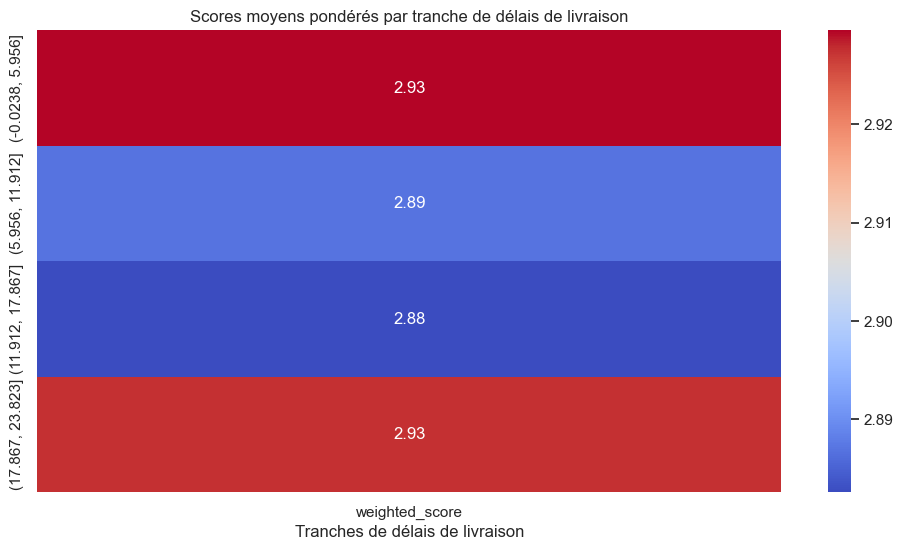

In [79]:
# Création de tranches de délais de livraison
df_filtered['delivery_bins'] = pd.cut(df_filtered['livree'], bins=4)

# Moyenne pondérée des scores par tranche de délai
df_pivot = df_filtered.groupby('delivery_bins').agg({
    'score_1': 'sum', 'score_2': 'sum', 'score_3': 'sum', 'score_4': 'sum'
})
df_pivot['weighted_score'] = (
    df_pivot['score_1'] * 1 +
    df_pivot['score_2'] * 2 +
    df_pivot['score_3'] * 3 +
    df_pivot['score_4'] * 4
#    df_pivot['score_5'] * 5
) / df_pivot.sum(axis=1)

# Heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df_pivot[['weighted_score']], annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.xlabel("Tranches de délais de livraison")
plt.ylabel("")
plt.title("Scores moyens pondérés par tranche de délais de livraison")
plt.show()

La moyenne est moins lisse quand le produit arrive vite ou très lentement !

#### 5 - Focus sur les scores 1 & 5 

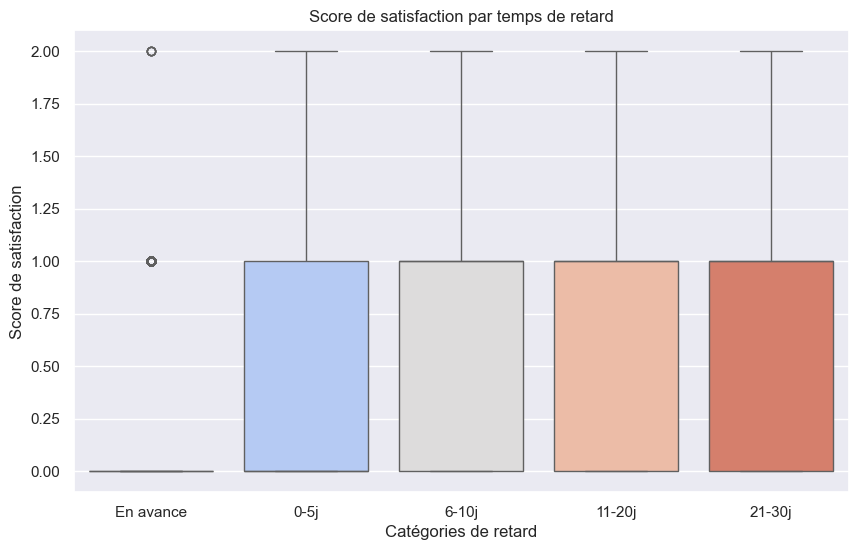

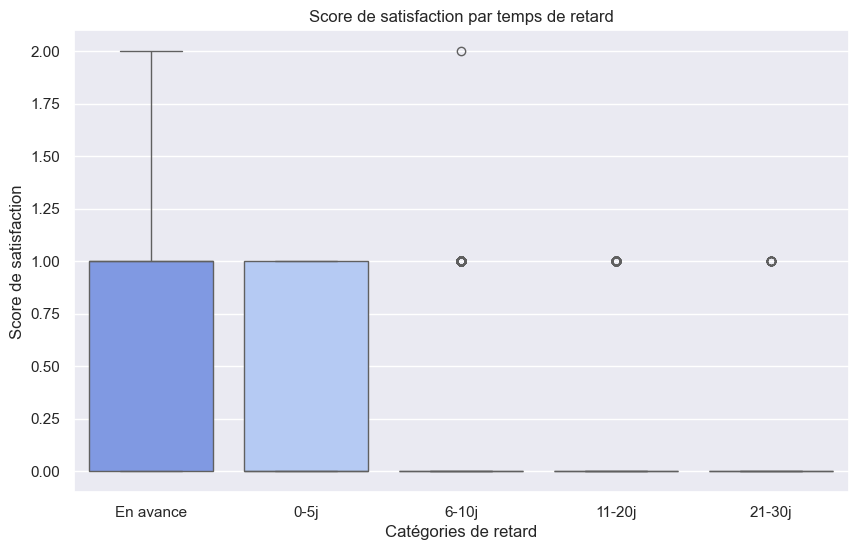

In [80]:

# Filtrage pour exclure les valeurs aberrantes (ex. délais trop extrêmes)
df_filtered = ventes[(ventes['retard'] >= -10) & (ventes['retard'] <= 30)]  # Retards entre -10 et 30 jours

# Boxplot : Score par catégories de retard
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered, x=pd.cut(df_filtered['retard'], bins=[-10, 0, 5, 10, 20, 30], labels=["En avance", "0-5j", "6-10j", "11-20j", "21-30j"]), y='score_1', palette="coolwarm")
plt.xlabel("Catégories de retard")
plt.ylabel("Score de satisfaction")
plt.title("Score de satisfaction par temps de retard")

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_filtered, x=pd.cut(df_filtered['retard'], bins=[-10, 0, 5, 10, 20, 30], labels=["En avance", "0-5j", "6-10j", "11-20j", "21-30j"]), y='score_5', palette="coolwarm")
plt.xlabel("Catégories de retard")
plt.ylabel("Score de satisfaction")
plt.title("Score de satisfaction par temps de retard")

plt.show()

#### 6 - Répartition des scores en fonction du retard  

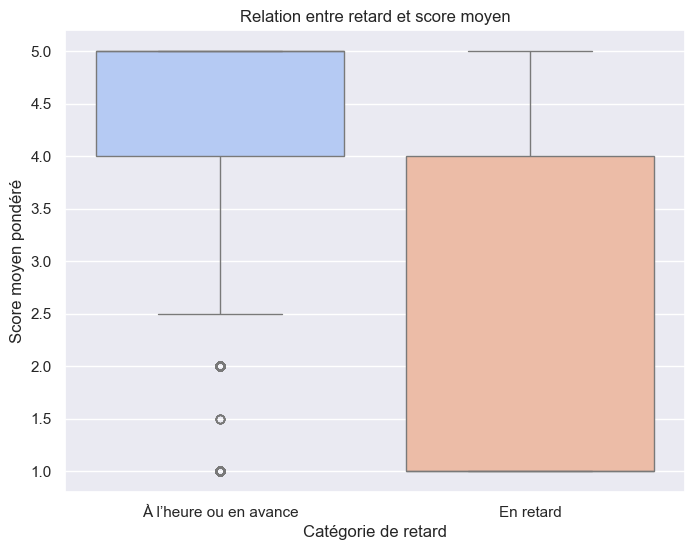

In [81]:

# Calculer le score moyen pondéré
ventes['weighted_score'] = (
    ventes['score_1'] * 1 +
    ventes['score_2'] * 2 +
    ventes['score_3'] * 3 +
    ventes['score_4'] * 4 +
    ventes['score_5'] * 5
) / (ventes[['score_1', 'score_2', 'score_3', 'score_4', 'score_5']].sum(axis=1))

# Créer le boxplot
plt.figure(figsize=(8, 6))
sns.boxplot(data=ventes, x='retard_categorie', y='weighted_score', palette="coolwarm")
plt.xlabel("Catégorie de retard")
plt.ylabel("Score moyen pondéré")
plt.title("Relation entre retard et score moyen")
plt.show()

Nous avons donc expliquer 6500 score 1 soit un peut plus de la moitier 

#### 7 - Insatisfaction des clients par catégorie de produit

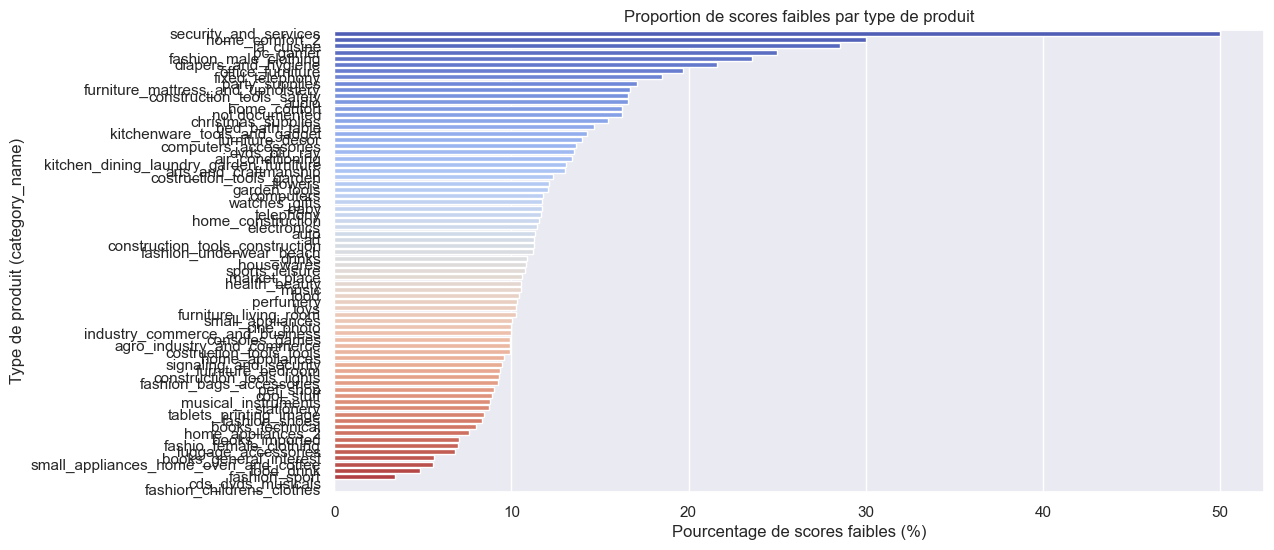

In [82]:
# Calculer le total des scores et la proportion des scores faibles (`score_1`) par catégorie
ventes_scores = ventes_achat_produits.groupby('category_name').agg(
    total_scores=('score_1', 'sum'),
    total_reviews=('score_1', 'count'),
    score_1_percentage=('score_1', lambda x: (x.sum() / x.count()) * 100)
).reset_index()

# Trier par pourcentage de scores faibles
ventes_scores = ventes_scores.sort_values(by='score_1_percentage', ascending=False)

# Visualisation : Barplot des scores faibles par catégorie
plt.figure(figsize=(12, 6))
sns.barplot(data=ventes_scores, x='score_1_percentage', y='category_name', palette="coolwarm")
plt.xlabel("Pourcentage de scores faibles (%)")
plt.ylabel("Type de produit (category_name)")
plt.title("Proportion de scores faibles par type de produit")
plt.show()

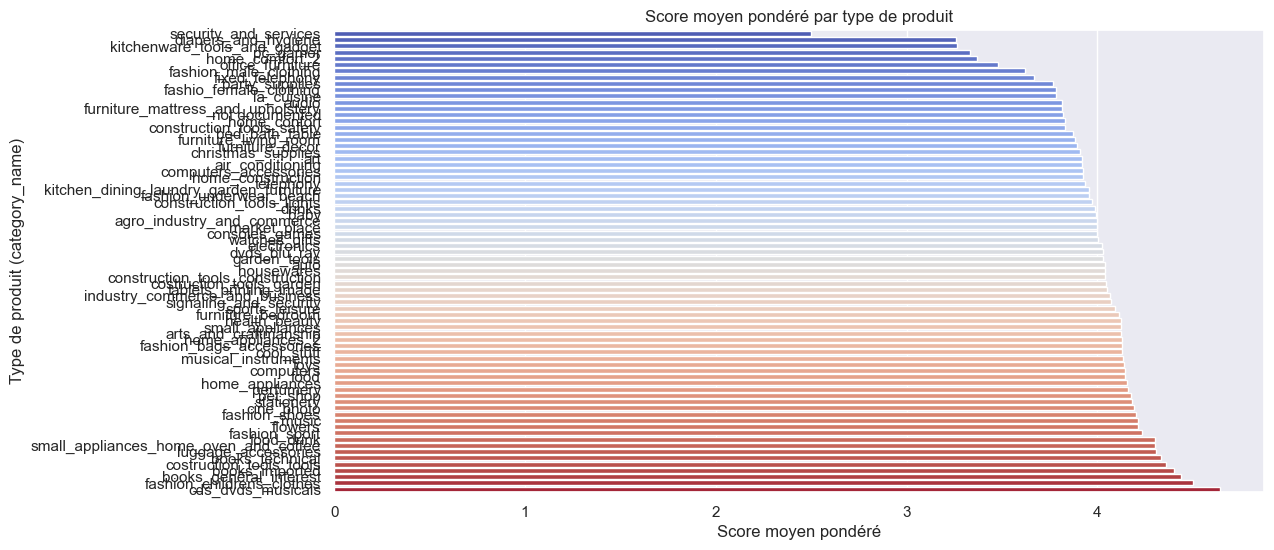

In [83]:
# Calculer le score moyen pondéré par catégorie
ventes_achat['weighted_score'] = (
    ventes_achat['score_1'] * 1 +
    ventes_achat['score_2'] * 2 +
    ventes_achat['score_3'] * 3 +
    ventes_achat['score_4'] * 4 +
    ventes_achat['score_5'] * 5
) / (ventes_achat[['score_1', 'score_2', 'score_3', 'score_4', 'score_5']].sum(axis=1))

df_avg_scores = ventes_achat.groupby('category_name').agg(
    avg_weighted_score=('weighted_score', 'mean')
).reset_index()

# Trier les catégories par score moyen pondéré
df_avg_scores = df_avg_scores.sort_values(by='avg_weighted_score', ascending=True)

# Visualisation : Barplot des scores moyens pondérés par catégorie
plt.figure(figsize=(12, 6))
sns.barplot(data=df_avg_scores, x='avg_weighted_score', y='category_name', palette="coolwarm")
plt.xlabel("Score moyen pondéré")
plt.ylabel("Type de produit (category_name)")
plt.title("Score moyen pondéré par type de produit")
plt.show()

In [84]:
valeurs_uniques = ventes_achat['category_name'].unique()
print(f"Valeurs distinctes dans ventes['score_1'] : {valeurs_uniques}")

Valeurs distinctes dans ventes['score_1'] : ['housewares' 'perfumery' 'auto' 'pet_shop' 'stationery' 'not documented'
 'furniture_decor' 'office_furniture' 'garden_tools'
 'computers_accessories' 'bed_bath_table' 'toys'
 'construction_tools_construction' 'telephony' 'health_beauty'
 'electronics' 'baby' 'cool_stuff' 'watches_gifts' 'air_conditioning'
 'sports_leisure' 'books_general_interest' 'small_appliances' 'food'
 'luggage_accessories' 'fashion_underwear_beach' 'christmas_supplies'
 'fashion_bags_accessories' 'musical_instruments'
 'construction_tools_lights' 'books_technical' 'costruction_tools_garden'
 'home_appliances' 'market_place' 'agro_industry_and_commerce'
 'party_supplies' 'home_confort' 'cds_dvds_musicals'
 'industry_commerce_and_business' 'consoles_games' 'furniture_bedroom'
 'construction_tools_safety' 'fixed_telephony' 'drinks'
 'kitchen_dining_laundry_garden_furniture' nan 'fashion_shoes'
 'home_construction' 'audio' 'home_appliances_2' 'fashion_male_clothing'
 'cin

#### 8 - Impacte des retards sur les catégories avec un haute insatisfaction 

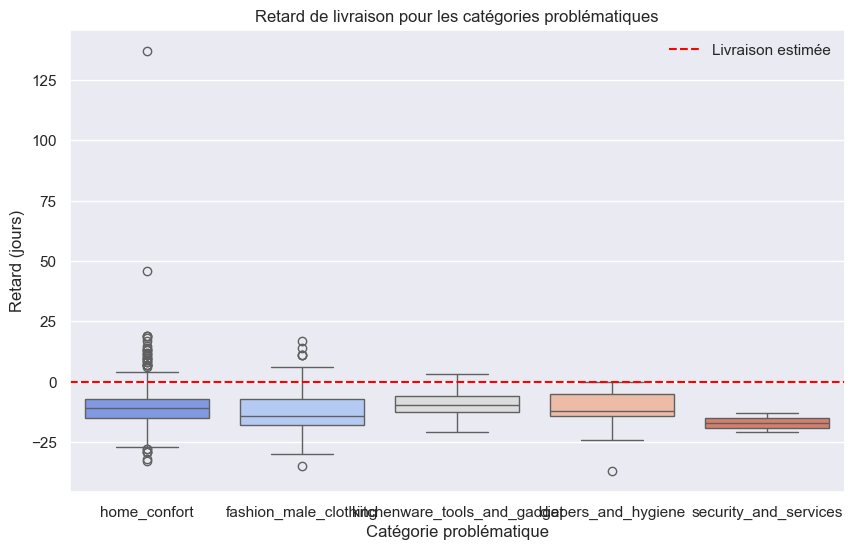

In [85]:
# Filtrer les catégories problématiques
categories_problemes = ['security_and_services', 'home_confort', 'kitchenware_tools_and_gadget', 'diapers_and_hygiene', 'fashion_male_clothing']
df_problemes = ventes_achat_produits[ventes_achat_produits['category_name'].isin(categories_problemes)]

# Calculer le retard (en jours)
df_problemes['retard'] = (df_problemes['delivered_customer'] - df_problemes['estimated_delivery']).dt.days

# Créer un boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_problemes, x='category_name', y='retard', palette="coolwarm")
plt.axhline(0, color='red', linestyle='--', label="Livraison estimée")
plt.xlabel("Catégorie problématique")
plt.ylabel("Retard (jours)")
plt.title("Retard de livraison pour les catégories problématiques")
plt.legend()
plt.show()

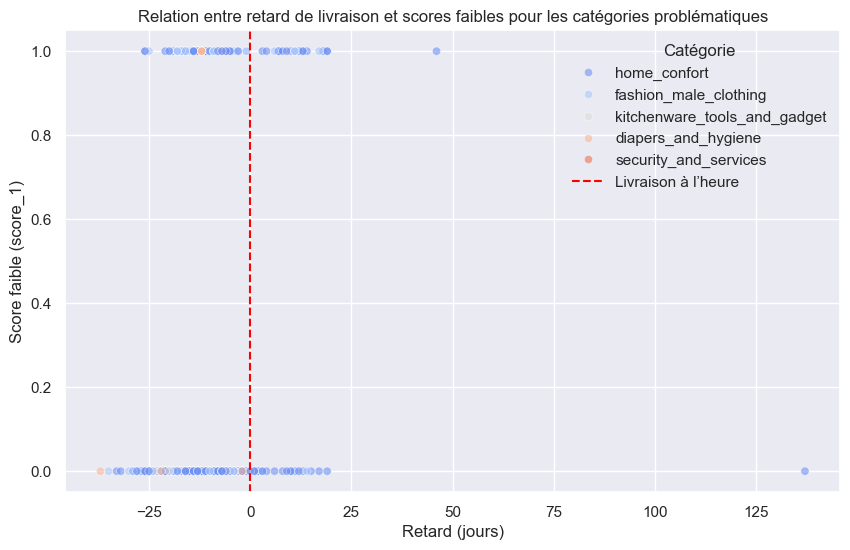

In [86]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_problemes, x='retard', y='score_1', hue='category_name', alpha=0.6, palette="coolwarm")
plt.axvline(0, color='red', linestyle='--', label="Livraison à l’heure")
plt.xlabel("Retard (jours)")
plt.ylabel("Score faible (score_1)")
plt.title("Relation entre retard de livraison et scores faibles pour les catégories problématiques")
plt.legend(title="Catégorie")
plt.show()

#### 9 - Totale des insatisfactions pour les catégories problématiques

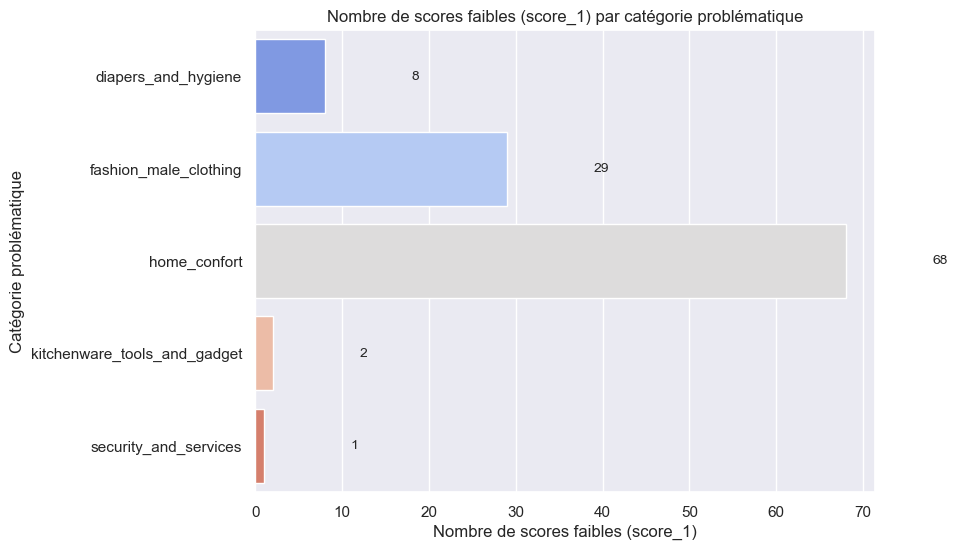

In [87]:
score_1_counts = df_problemes.groupby('category_name')['score_1'].sum().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(data=score_1_counts, x='score_1', y='category_name', palette="coolwarm")
plt.xlabel("Nombre de scores faibles (score_1)")
plt.ylabel("Catégorie problématique")
plt.title("Nombre de scores faibles (score_1) par catégorie problématique")
for i, count in enumerate(score_1_counts['score_1']):
    plt.text(count + 10, i, f"{int(count)}", va='center', fontsize=10)
plt.show()

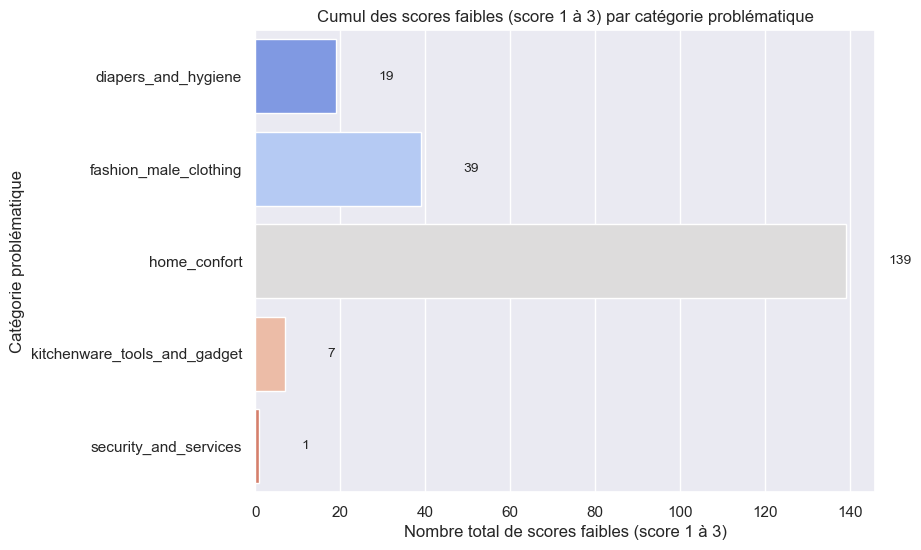

In [88]:
# Calculer le cumul des scores faibles (1 à 3) pour chaque catégorie problématique
score_low_counts = df_problemes.groupby('category_name').agg(
    score_low_total=('score_1', 'sum'),
    score_medium_total=('score_2', 'sum'),
    score_medium_high_total=('score_3', 'sum')
).reset_index()

# Ajouter une colonne pour le cumul des scores faibles
score_low_counts['total_score_1_to_3'] = (
    score_low_counts['score_low_total'] +
    score_low_counts['score_medium_total'] +
    score_low_counts['score_medium_high_total']
)

# Créer un barplot
plt.figure(figsize=(8, 6))
sns.barplot(data=score_low_counts, x='total_score_1_to_3', y='category_name', palette="coolwarm")
plt.xlabel("Nombre total de scores faibles (score 1 à 3)")
plt.ylabel("Catégorie problématique")
plt.title("Cumul des scores faibles (score 1 à 3) par catégorie problématique")
for i, count in enumerate(score_low_counts['total_score_1_to_3']):
    plt.text(count + 10, i, f"{int(count)}", va='center', fontsize=10)
plt.show()

In [89]:
ventes_achat_produits.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107975 entries, 0 to 113424
Data columns (total 75 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   order_id            107975 non-null  object        
 1   customer_id         107975 non-null  object        
 2   purchase_timestamp  107975 non-null  datetime64[us]
 3   approved_at         107961 non-null  datetime64[us]
 4   delivered_carrier   107974 non-null  datetime64[us]
 5   delivered_customer  107975 non-null  datetime64[us]
 6   estimated_delivery  107975 non-null  datetime64[us]
 7   status              107975 non-null  object        
 8   annee               107975 non-null  int32         
 9   mois                107975 non-null  int32         
 10  annee_mois          107975 non-null  int32         
 11  jour                107975 non-null  int32         
 12  annee_jour          107975 non-null  int32         
 13  jour_semaine        107975 non-nul

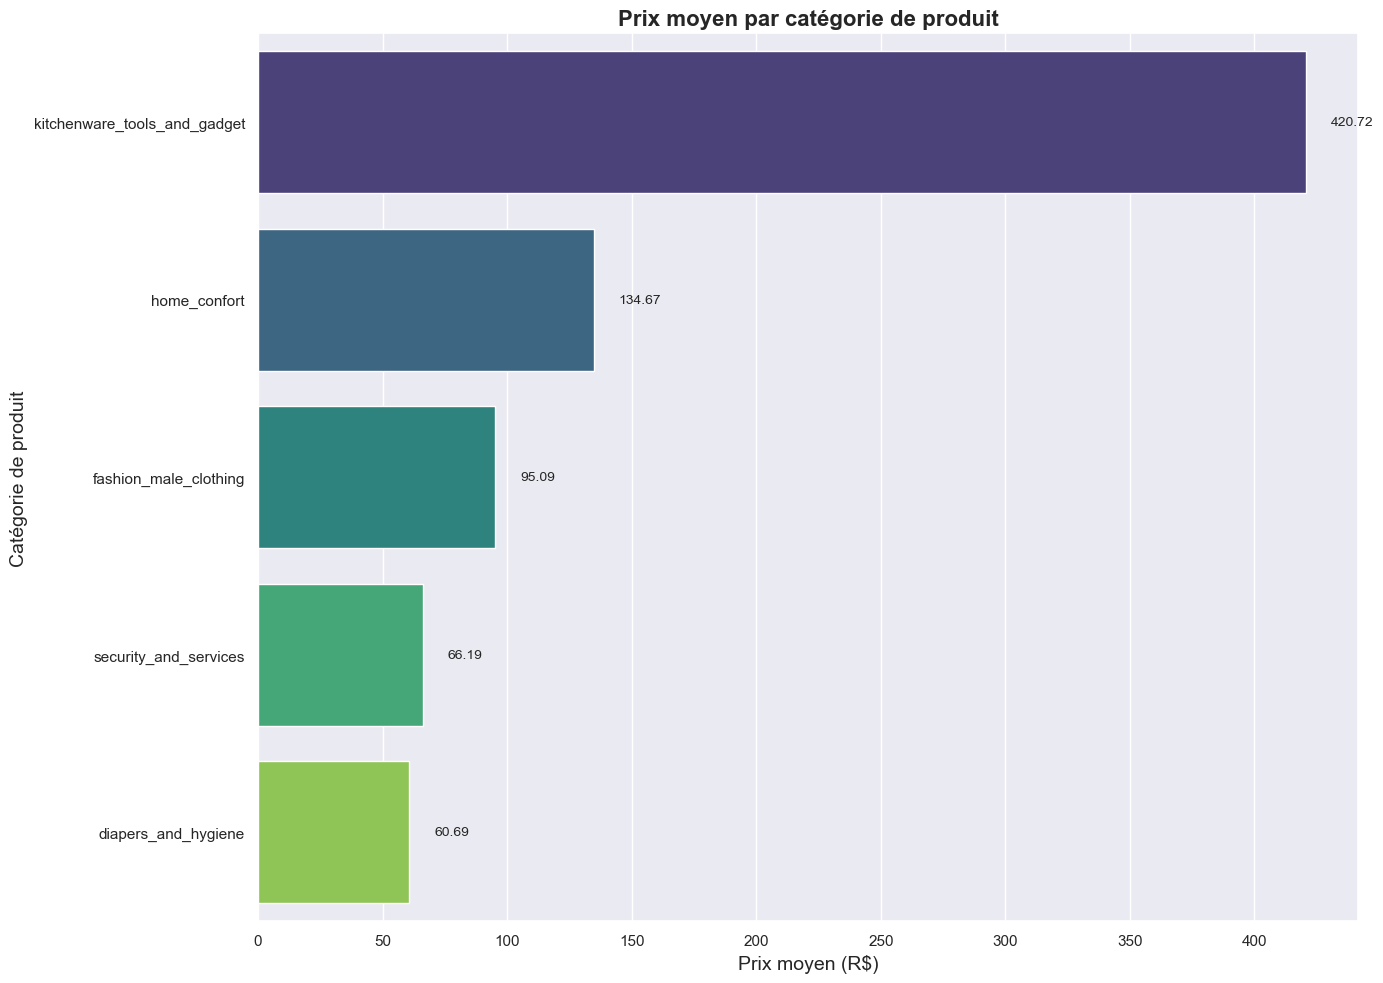

In [90]:
# Créer une colonne "price" en fonction du mode de paiement
ventes_payement['price'] = np.select(
    [
        ventes_payement['payment_method'] == 'Boleto',
        ventes_payement['payment_method'] == 'Carte de crédit',
        ventes_payement['payment_method'] == 'Carte de débit',
        ventes_payement['payment_method'] == 'Voucher',
        ventes_payement['payment_method'].isnull()
    ],
    [
        ventes_payement['value_boleto'],
        ventes_payement['value_credit_card'],
        ventes_payement['value_debit_card'],
        ventes_payement['value_voucher'],
        ventes_payement['value_not_defined']
    ],
    default=0  # Par défaut, mettre 0 si aucun mode de paiement valide n'est trouvé
)

df_problemes = ventes_payement[ventes_payement['category_name'].isin(categories_problemes)]
prix_moyen_par_categorie = df_problemes.groupby('category_name')['price'].std().reset_index()


prix_moyen_par_categorie = prix_moyen_par_categorie.sort_values(by='price', ascending=False)

# Ajuster la taille de la figure et l'espacement
plt.figure(figsize=(14, 10))  # Largeur = 14, Hauteur = 10
sns.barplot(data=prix_moyen_par_categorie, x='price', y='category_name', palette="viridis")
plt.xlabel("Prix moyen (R$)", fontsize=14)
plt.ylabel("Catégorie de produit", fontsize=14)
plt.title("Prix moyen par catégorie de produit", fontsize=16, weight='bold')

# Afficher les valeurs sur les barres
for i, price in enumerate(prix_moyen_par_categorie['price']):
    plt.text(price + 10, i, f"{price:.2f}", va='center', fontsize=10)

# Ajuster les marges pour éviter que les étiquettes soient coupées
plt.tight_layout()
plt.show()

In [91]:
valeurs_uniques = ventes_payement['payment_method'].unique()
print(f"Valeurs distinctes dans ventes['score_1'] : {valeurs_uniques}")

Valeurs distinctes dans ventes['score_1'] : ['Carte de crédit' 'Boleto' 'Carte de débit' 'Voucher' nan]


### 3/ Analyse des produits coûteux et des attentes
#### 1 - Prix moyen de chaque catégorie d'article

Objectif : Identifier si les produits coûteux répondent aux attentes des clients en analysant les scores faibles.

Dimensions :
Prix moyen (value_* selon le mode de paiement).
Catégorie de produit (category_name).
Score (score_1, score_2, score_3, score_4, score_5).

- Barplot : Prix moyen par catégorie de produit.
- Heatmap : Proportion de scores faibles (1 à 3) par prix et catégorie.
- Scatter Plot : Scores faibles (1) en fonction du prix des produits.
- Boxplot : Score moyen pondéré par catégorie pour les produits coûteux (Top 10).
- Histogramme : Distribution des scores faibles pour les produits au-dessus du prix médian.
- Scatter Plot : Délai de livraison vs prix pour les produits coûteux.
- Barplot : Catégories avec la plus forte proportion de scores faibles.
- Boxplot : Scores moyens par mode de paiement pour les produits coûteux.
- Heatmap : Scores faibles par région et prix moyen.
- Line chart : Évolution des scores moyens pour les produits coûteux dans le temps.

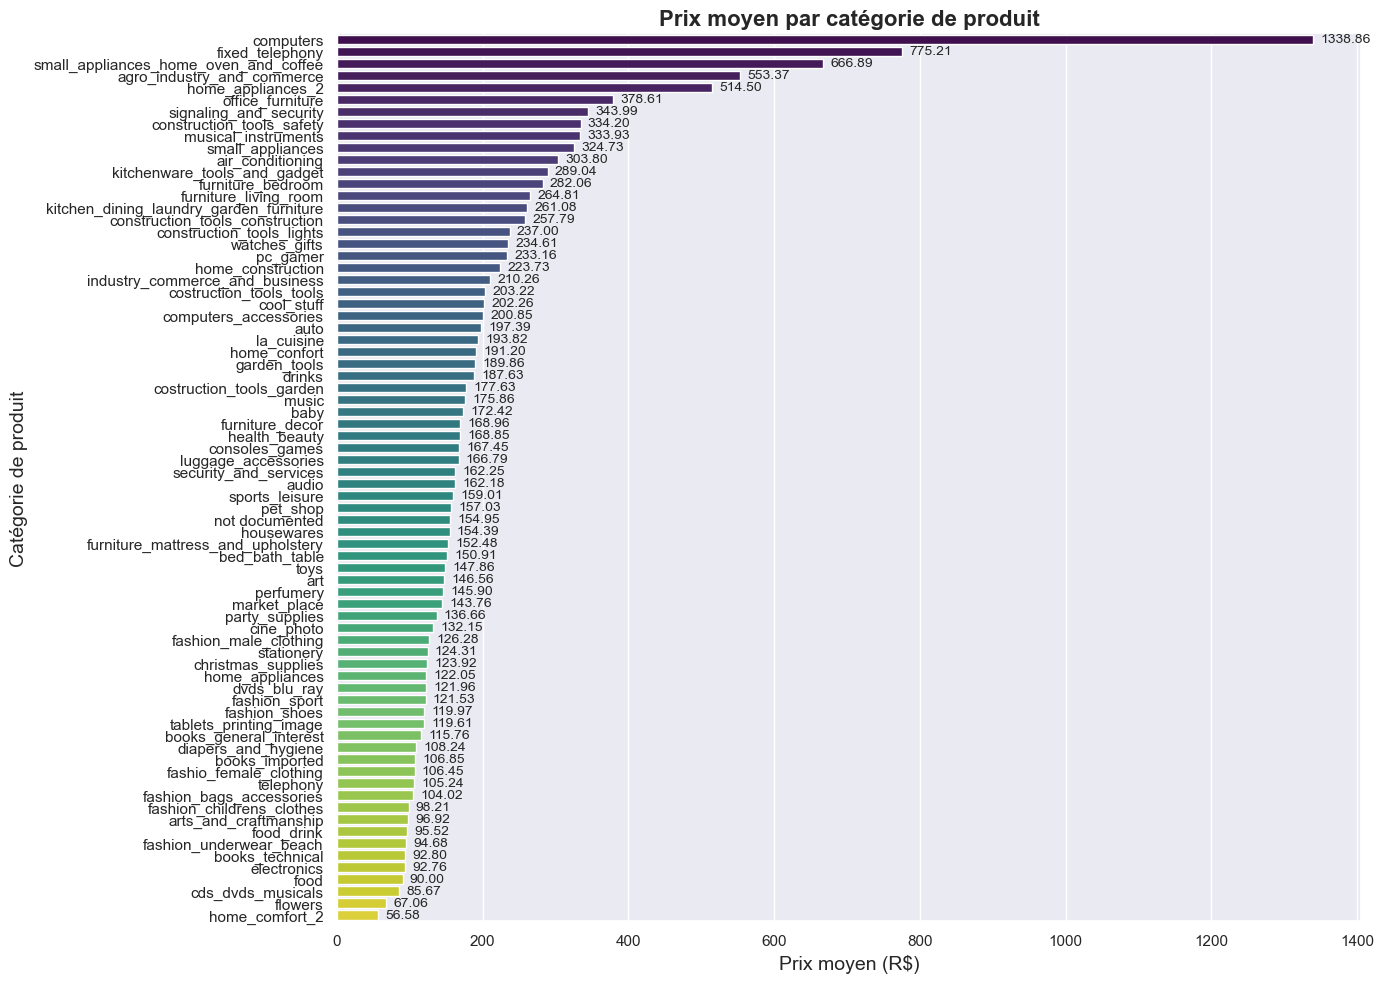

In [92]:
# Créer une colonne "price" en fonction du mode de paiement
ventes_payement['price'] = np.select(
    [
        ventes_payement['payment_method'] == 'Boleto',
        ventes_payement['payment_method'] == 'Carte de crédit',
        ventes_payement['payment_method'] == 'Carte de débit',
        ventes_payement['payment_method'] == 'Voucher',
        ventes_payement['payment_method'].isnull()
    ],
    [
        ventes_payement['value_boleto'],
        ventes_payement['value_credit_card'],
        ventes_payement['value_debit_card'],
        ventes_payement['value_voucher'],
        ventes_payement['value_not_defined']
    ],
    default=0  # Par défaut, mettre 0 si aucun mode de paiement valide n'est trouvé
)


prix_moyen_par_categorie = ventes_payement.groupby('category_name')['price'].mean().reset_index()


prix_moyen_par_categorie = prix_moyen_par_categorie.sort_values(by='price', ascending=False)

# Ajuster la taille de la figure et l'espacement
plt.figure(figsize=(14, 10))  # Largeur = 14, Hauteur = 10
sns.barplot(data=prix_moyen_par_categorie, x='price', y='category_name', palette="viridis")
plt.xlabel("Prix moyen (R$)", fontsize=14)
plt.ylabel("Catégorie de produit", fontsize=14)
plt.title("Prix moyen par catégorie de produit", fontsize=16, weight='bold')

# Afficher les valeurs sur les barres
for i, price in enumerate(prix_moyen_par_categorie['price']):
    plt.text(price + 10, i, f"{price:.2f}", va='center', fontsize=10)

# Ajuster les marges pour éviter que les étiquettes soient coupées
plt.tight_layout()
plt.show()

In [104]:
# Filtrer les produits coûteux (dernier quartile des prix)
price_threshold = ventes_payement['price'].quantile(0.75)
df_couteux = ventes_payement[ventes_payement['price'] >= price_threshold].copy()

# Vérifier et calculer le score moyen pondéré
df_couteux['total_score'] = df_couteux[['score_1', 'score_2', 'score_3', 'score_4', 'score_5']].sum(axis=1)
df_couteux = df_couteux[df_couteux['total_score'] > 0]  # Exclure les lignes avec total_score = 0

df_couteux['weighted_score'] = (
    (df_couteux['score_1'] * 1 +
     df_couteux['score_2'] * 2 +
     df_couteux['score_3'] * 3 +
     df_couteux['score_4'] * 4 +
     df_couteux['score_5'] * 5)
    / df_couteux['total_score']
)

# Groupement et extraction des Top 10 catégories par prix moyen
top_categories = (
    df_couteux.groupby('category_name')['price'].mean()
    .sort_values(ascending=False)
    .head(10)
)

# Affichage des résultats
print("Top 10 des catégories les plus coûteuses :")
print(top_categories)

Top 10 des catégories les plus coûteuses :
category_name
fixed_telephony                          2075.345699
computers                                1357.971775
dvds_blu_ray                             1005.155000
small_appliances_home_oven_and_coffee     940.326731
kitchenware_tools_and_gadget              932.772500
signaling_and_security                    890.902581
agro_industry_and_commerce                855.416615
books_imported                            804.960000
drinks                                    782.418833
art                                       713.802500
Name: price, dtype: float64


#### 2 - Proportion des scores faible par prix et catégorie de produit

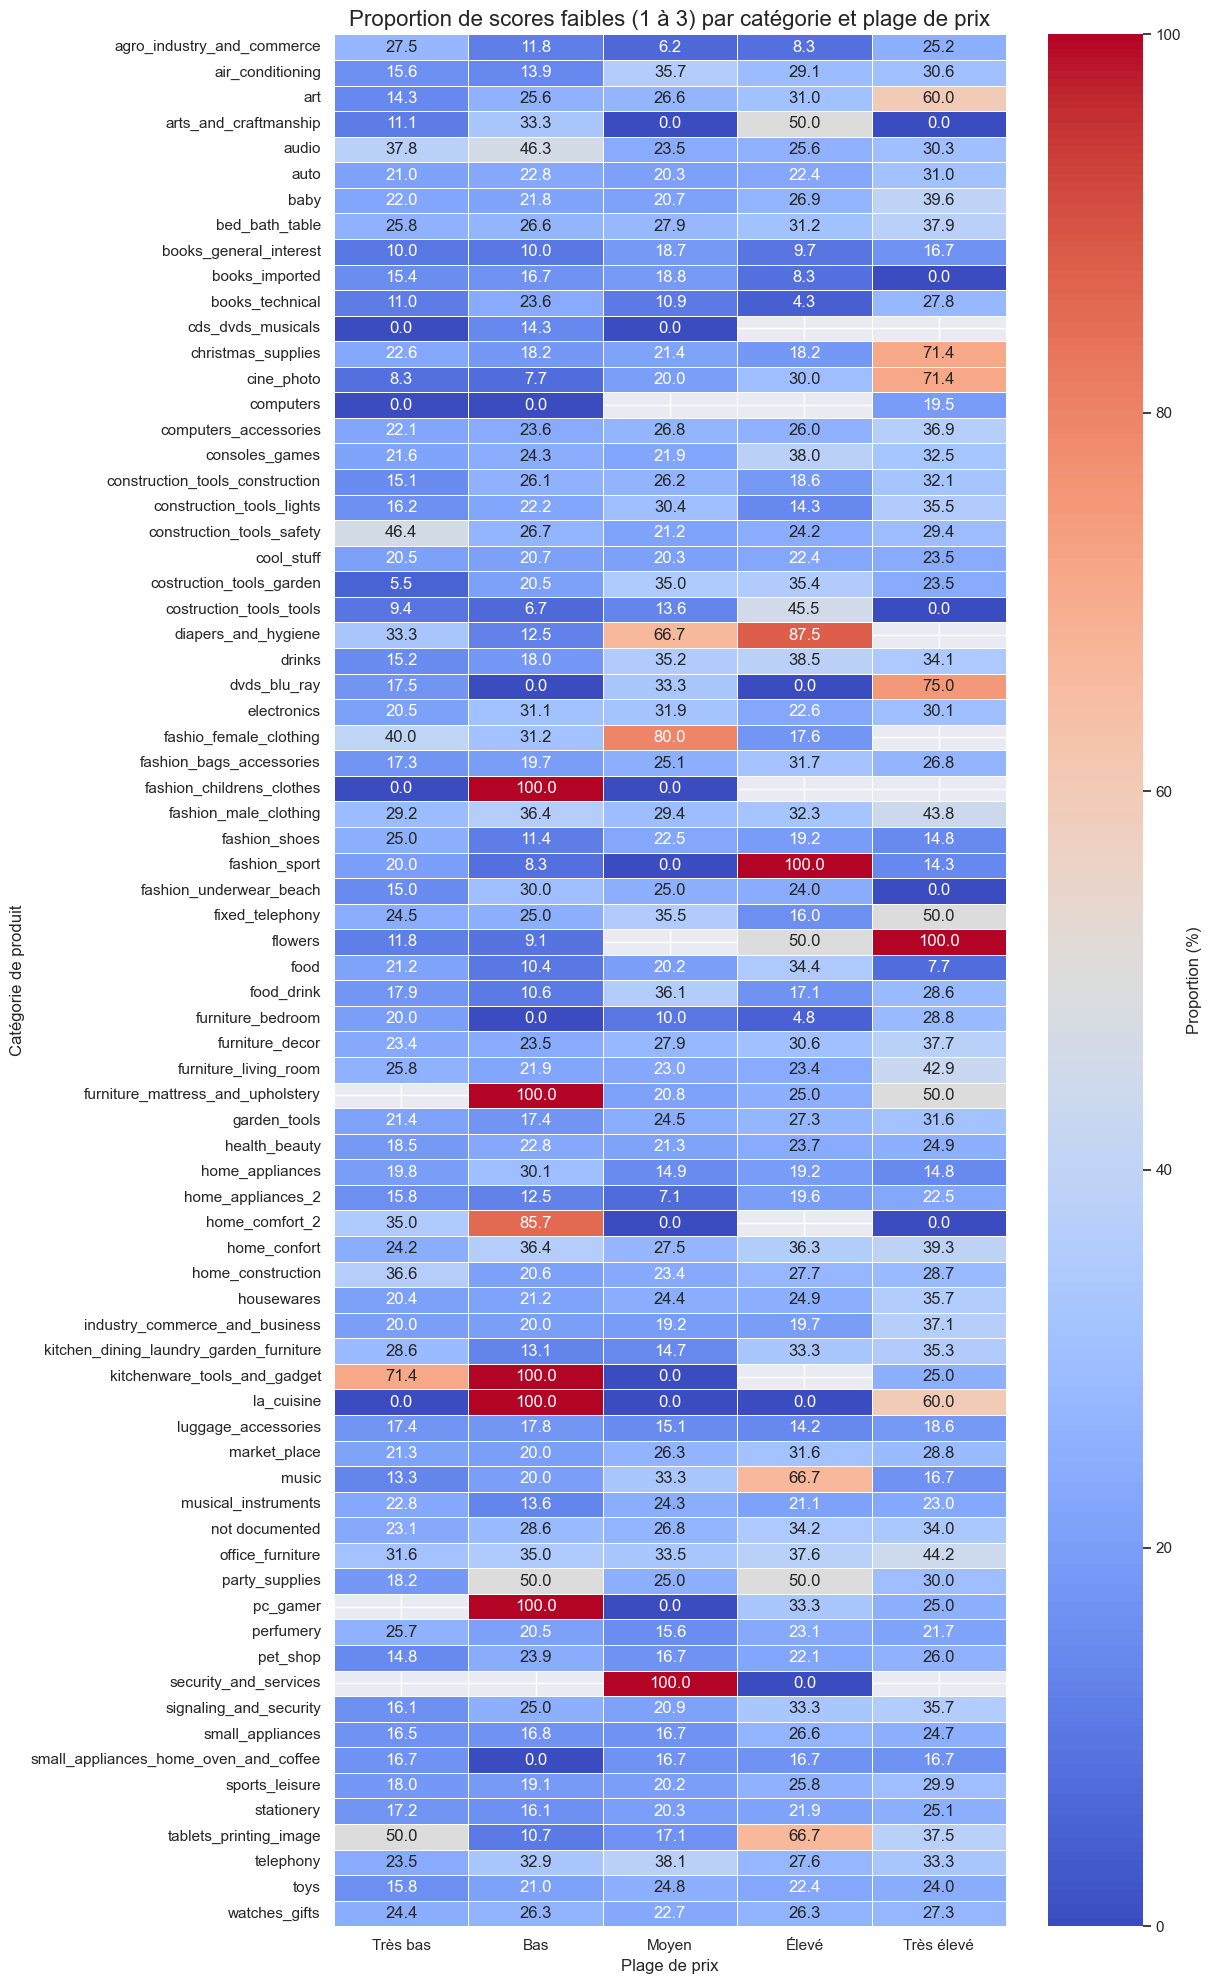

In [98]:
# Définir les scores faibles comme étant de 1 à 3
ventes_payement['is_score_low'] = ventes_payement[['score_1', 'score_2', 'score_3']].sum(axis=1) > 0

# Calculer le prix moyen des produits
#ventes_payement['price'] = ventes_payement[['value_boleto', 'value_credit_card', 'value_debit_card', 'value_voucher', 'value_not_defined']].max(axis=1)

# Grouper les données par catégorie et plage de prix
ventes_payement['price_range'] = pd.qcut(ventes_payement['price'], q=5, labels=["Très bas", "Bas", "Moyen", "Élevé", "Très élevé"])
heatmap_data = ventes_payement.groupby(['category_name', 'price_range']).agg(
    total_scores=('is_score_low', 'sum'),
    total_reviews=('is_score_low', 'count')
).reset_index()

# Calculer la proportion des scores faibles
heatmap_data['low_score_percentage'] = (heatmap_data['total_scores'] / heatmap_data['total_reviews']) * 100

# Réorganiser les données en pivot pour créer une heatmap
heatmap_pivot = heatmap_data.pivot(index='category_name', columns='price_range', values='low_score_percentage')

# Créer la heatmap
plt.figure(figsize=(12, 20))
sns.heatmap(heatmap_pivot, cmap='coolwarm', annot=True, fmt=".1f", linewidths=0.5, cbar_kws={'label': 'Proportion (%)'})
plt.title("Proportion de scores faibles (1 à 3) par catégorie et plage de prix", fontsize=16)
plt.xlabel("Plage de prix")
plt.ylabel("Catégorie de produit")
plt.tight_layout()
plt.show()

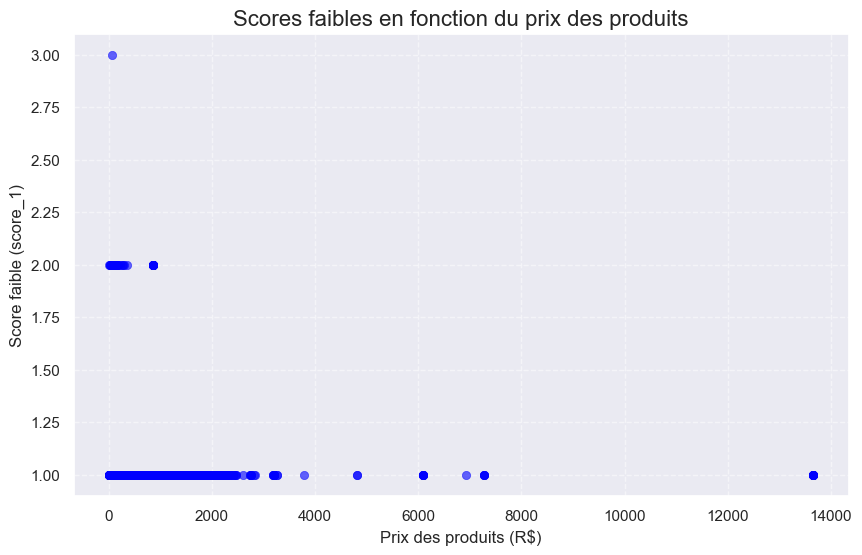

In [102]:
# Filtrer uniquement les scores faibles (score_1 > 0)
df_scores_faibles = ventes_payement[ventes_payement['score_1'] > 0]

# Calculer le prix moyen des produits
df_scores_faibles['price'] = df_scores_faibles[
    ['value_boleto', 'value_credit_card', 'value_debit_card', 'value_voucher', 'value_not_defined']
].max(axis=1)

# Créer un scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_scores_faibles, x='price', y='score_1', alpha=0.6, color='blue', edgecolor=None)
plt.xlabel("Prix des produits (R$)")
plt.ylabel("Score faible (score_1)")
plt.title("Scores faibles en fonction du prix des produits", fontsize=16)
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

Ce graphique nous indique qu'il faut ajouter une dimension pour continuer notre analyse, bien qu'une forte proportion des note faible est attibué à des produit de bas prix, un score faible et une mauvaise note ne semble pas être corrélés.

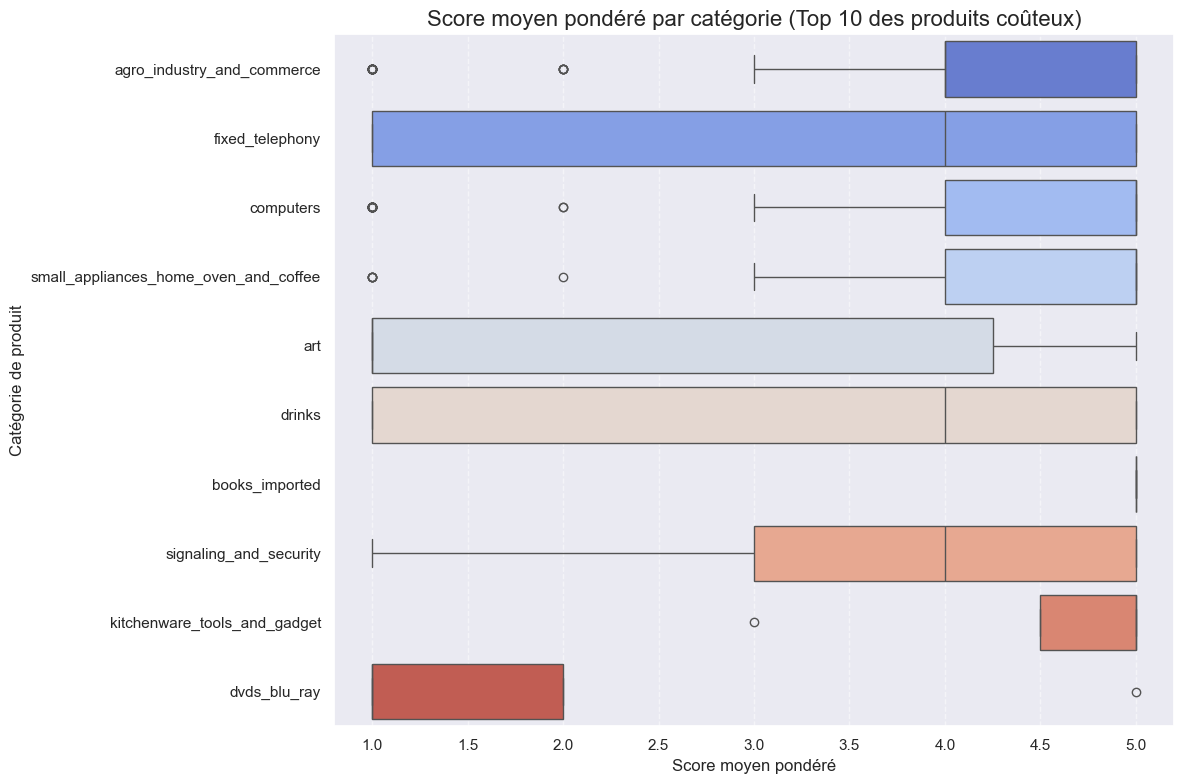

In [103]:
# Définir les produits coûteux comme ceux appartenant au dernier quartile des prix
price_threshold = ventes_payement['price'].quantile(0.75)
df_couteux = ventes_payement[ventes_payement['price'] >= price_threshold]

# Calculer le score moyen pondéré
df_couteux['weighted_score'] = (
    df_couteux['score_1'] * 1 +
    df_couteux['score_2'] * 2 +
    df_couteux['score_3'] * 3 +
    df_couteux['score_4'] * 4 +
    df_couteux['score_5'] * 5
) / (df_couteux[['score_1', 'score_2', 'score_3', 'score_4', 'score_5']].sum(axis=1))

# Extraire les Top 10 catégories par prix moyen
top_categories = (
    df_couteux.groupby('category_name')['price'].mean()
    .sort_values(ascending=False)
    .head(10)
    .index
)

df_top_categories = df_couteux[df_couteux['category_name'].isin(top_categories)]

# Créer le boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=df_top_categories, x='weighted_score', y='category_name', palette="coolwarm", orient='h')
plt.xlabel("Score moyen pondéré")
plt.ylabel("Catégorie de produit")
plt.title("Score moyen pondéré par catégorie (Top 10 des produits coûteux)", fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

On constate qu'un prix élevé n'est pas nécessairement liée à une note élevé. Attention, ici nous prenons le prix moins dans le dernier cartil pour chaque catégorie, c'est pourquoi drinks, art & dvds_blu_ray se trouve dans cette liste. Cela nous permet de nous abstraire de la moyen général des prix sur un produits pour analyse les scores sur les produits du derniers quartil uniquement. 

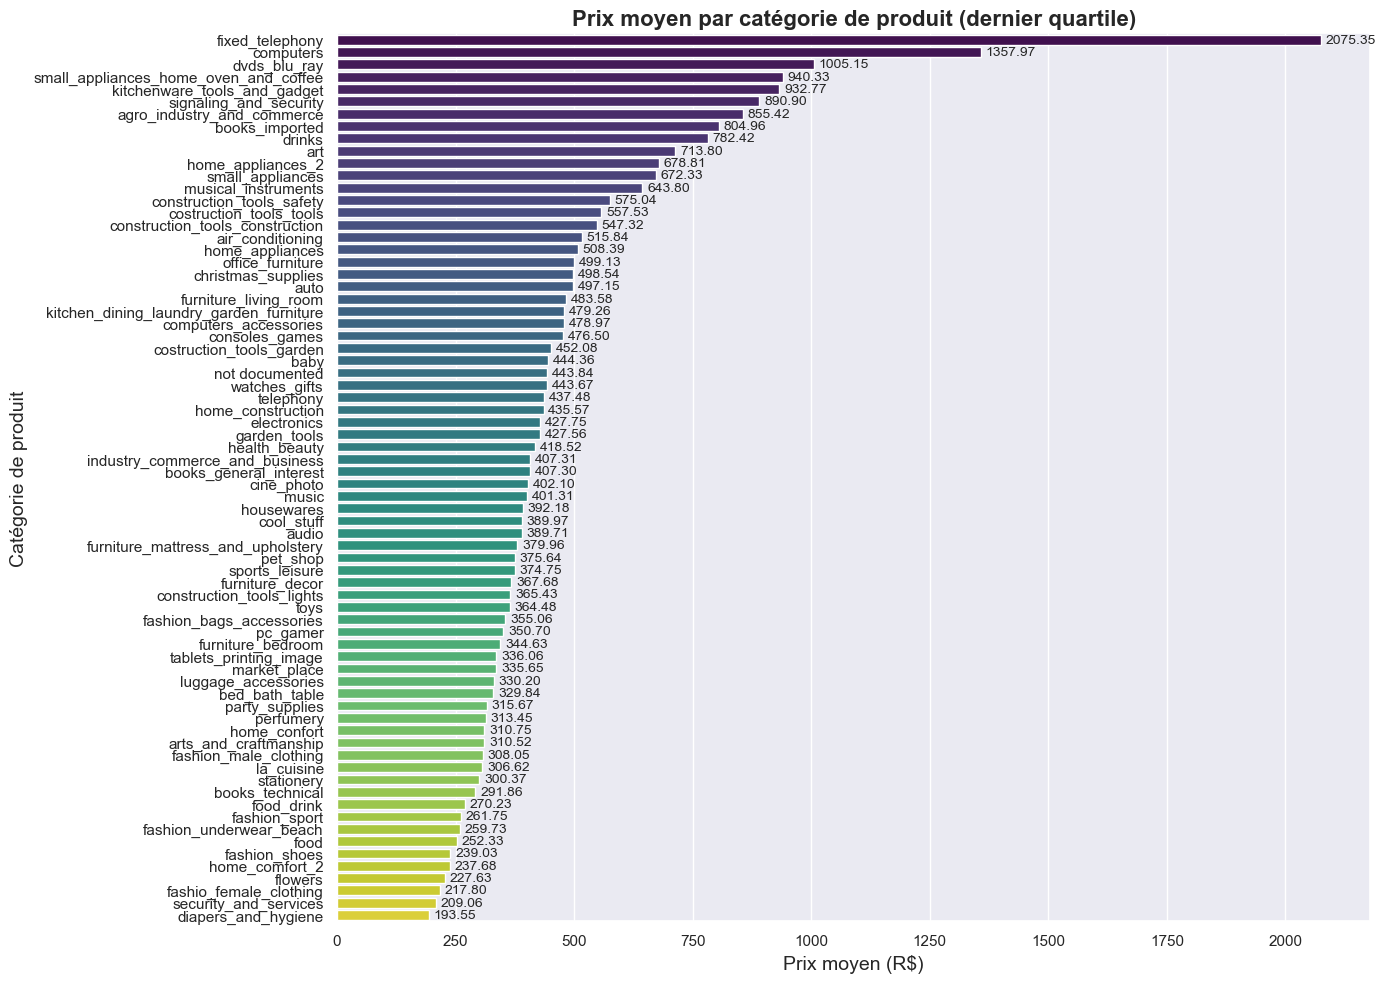

In [105]:
# Créer une colonne "price" en fonction du mode de paiement
ventes_payement['price'] = np.select(
    [
        ventes_payement['payment_method'] == 'Boleto',
        ventes_payement['payment_method'] == 'Carte de crédit',
        ventes_payement['payment_method'] == 'Carte de débit',
        ventes_payement['payment_method'] == 'Voucher',
        ventes_payement['payment_method'].isnull()
    ],
    [
        ventes_payement['value_boleto'],
        ventes_payement['value_credit_card'],
        ventes_payement['value_debit_card'],
        ventes_payement['value_voucher'],
        ventes_payement['value_not_defined']
    ],
    default=0  # Par défaut, mettre 0 si aucun mode de paiement valide n'est trouvé
)

# Filtrer les produits coûteux (dernier quartile des prix)
price_threshold = ventes_payement['price'].quantile(0.75)
df_couteux = ventes_payement[ventes_payement['price'] >= price_threshold].copy()

# Calculer le prix moyen par catégorie
prix_moyen_par_categorie = (
    df_couteux.groupby('category_name')['price']
    .mean()
    .reset_index()
    .sort_values(by='price', ascending=False)
)

# Visualiser les résultats
plt.figure(figsize=(14, 10))  # Largeur = 14, Hauteur = 10
sns.barplot(data=prix_moyen_par_categorie, x='price', y='category_name', palette="viridis")
plt.xlabel("Prix moyen (R$)", fontsize=14)
plt.ylabel("Catégorie de produit", fontsize=14)
plt.title("Prix moyen par catégorie de produit (dernier quartile)", fontsize=16, weight='bold')

# Afficher les valeurs sur les barres
for i, price in enumerate(prix_moyen_par_categorie['price']):
    plt.text(price + 10, i, f"{price:.2f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()